# Notebook to run full analysis for a flight

## Basic imports and setup

In [6]:
import sys
# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
sys.path.append(root_path)

# Package to read yml files
import yaml
# Package to handle file paths
import os
# Package to deal with DataFrames
import pandas as pd
# Package to plot stuff
import matplotlib.pyplot as plt
# Package to make nicer plots
import seaborn as sns
# Package for numerical and array handling
import numpy as np
# Package for math stuff
import math
# Package to read and write to .sqlite files
import sqlite3
# Package to keep track of time
import datetime
# Package to decode binary data
import struct
# Package for statistical optimization
import statsmodels.api as sm
# Package for minimization
from scipy.optimize import minimize

# Function to clear output from jupyter notebook
from IPython.display import clear_output
# Package for compressing dataframes into file
from src.data import compressors
# Package for defining and fitting weather models
from src.models import weather
# Utilities package
from src.common import utils
# Package for interpolating and estimating weather
from src.analysis import weather_interpolator
# Package to handle and create plots
from src.frontend import plotter

%matplotlib inline

# Path from this notebook to the root directory
root_path = os.path.normpath(root_path)
# Path from root to the desired config file
config_path_from_root = os.path.normpath('config/config.yml')
# Defining path from this notebook to config file
config_path = os.path.join(root_path, config_path_from_root)

# Loading config file
with open(config_path, 'r',  encoding='utf8') as file:
    config = yaml.safe_load(file)

# Defining "clear-output" function to feed into logger
def clear():
    clear_output(wait=True)

# Creates an instance of a logger class to log all that happens, optional (but encouraged).
logger = utils.Logger(config, clear_function=None)

pltr = plotter.Plotter(config)

# Defining location of data
flights_database_1 = '/Users/dumindu/Documents/Repositories/Erdos Project/CSV/KLAX_KJFK_2023-01-01_2023-01-31.sqlite'
flights_database_2 = '/Users/dumindu/Documents/Repositories/FlightPath/data/flight/KLAX_KJFK_2023-07-01_2023-07-31.sqlite'

# weather_database = '../data/weather/Weather-US_2022-12-31_2023-02-01.sqlite'

departure_airport = flights_database_1.split('/')[-1].split('_')[0]
arrival_airport = flights_database_1.split('/')[-1].split('_')[1]
month = flights_database_1.split('/')[-1].split('_')[3].split('-')[1]

flights_thresh = 100

if month == '01':
    month = 'January'
elif month == '07':
    month = 'July'
    

flights_connection_1 = sqlite3.connect(flights_database_1)
flights_connection_2 = sqlite3.connect(flights_database_2)


flights_1 = pd.read_sql_query("""
    SELECT fs.*,
    fi.*,
    fa.*,
    ofi.time AS opt_time,
    ofi.fuel AS opt_fuel,
    ofi.distance AS opt_distance,
    ofi.wind AS opt_wind,
    ofi.air_density AS opt_air_density,
    ofi.air_pressure AS opt_air_pressure,
    ofi.clouds AS opt_clouds,
    ofi.severity AS opt_severity
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    LEFT JOIN optimal_flights_integrals AS ofi ON ofi.flight_id = fs.flight_id
    """, flights_connection_1).dropna()

flights_2 = pd.read_sql_query("""
    SELECT fs.*,
    fi.*,
    fa.*,
    ofi.time AS opt_time,
    ofi.fuel AS opt_fuel,
    ofi.distance AS opt_distance,
    ofi.wind AS opt_wind,
    ofi.air_density AS opt_air_density,
    ofi.air_pressure AS opt_air_pressure,
    ofi.clouds AS opt_clouds,
    ofi.severity AS opt_severity
    FROM flights AS fs
    JOIN flights_integrals AS fi ON fi.flight_id = fs.flight_id
    LEFT JOIN flights_aircraft AS fa ON fa.icao24 = fs.icao24
    LEFT JOIN optimal_flights_integrals AS ofi ON ofi.flight_id = fs.flight_id
    """, flights_connection_2).dropna()


flights_connection_1.close()
flights_connection_2.close()


In [29]:
columns = list(set(list(flights_1.columns)) & set(list(flights_2.columns)))

flights_1 = flights_1[columns]
flights_2 = flights_2[columns]

In [30]:
flights = pd.concat([flights_1, flights_2], ignore_index=True)

flights['airline'] = flights['callsign'].apply(lambda x: x[:3])

aircrafts, counts = np.unique(flights['typecode'], return_counts=True)

mask = counts > flights_thresh
aircrafts = aircrafts[mask]
counts = counts[mask]

flights = flights[flights['typecode'].apply(lambda x: x in aircrafts)]

flights['time'] = flights['time'].apply(lambda x: struct.unpack('Q', x)[0])
flights['opt_time'] = flights['opt_time'].apply(lambda x: struct.unpack('Q', x)[0])

## Superficial Flights Analysis

### Number of Flights by Airline

Done


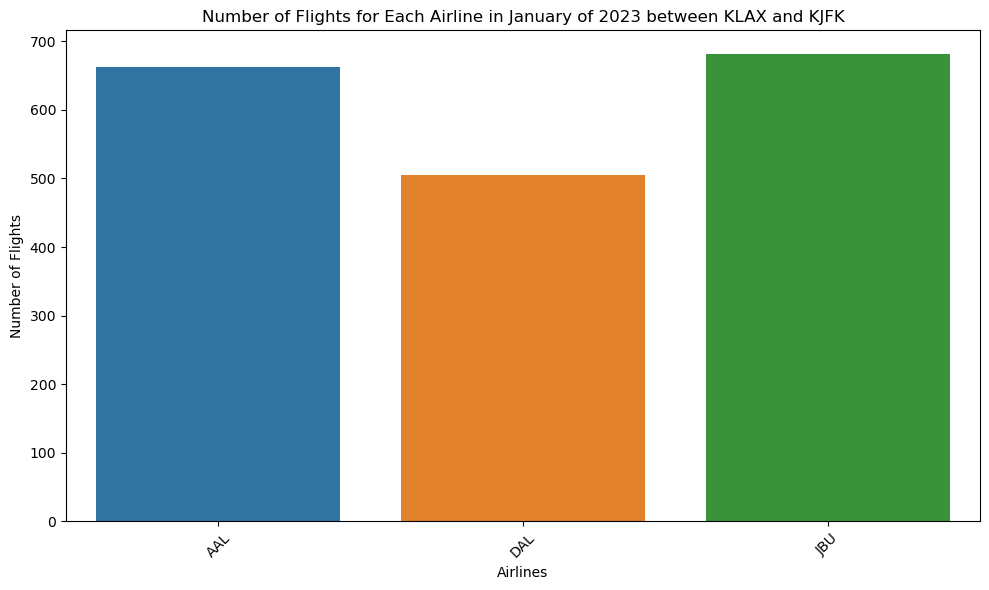

In [31]:
airlines, counts = np.unique(flights['airline'], return_counts=True)

data = pd.DataFrame({
    'Airlines': airlines,
    'Flight Counts': counts
})

# Creating the plot using the fig, ax approach
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Airlines', y='Flight Counts', data=data, ax=ax)
ax.set_title(f'Number of Flights for Each Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.set_xlabel('Airlines')
ax.set_ylabel('Number of Flights')
plt.xticks(rotation=45)

fig.tight_layout()
print("Done")

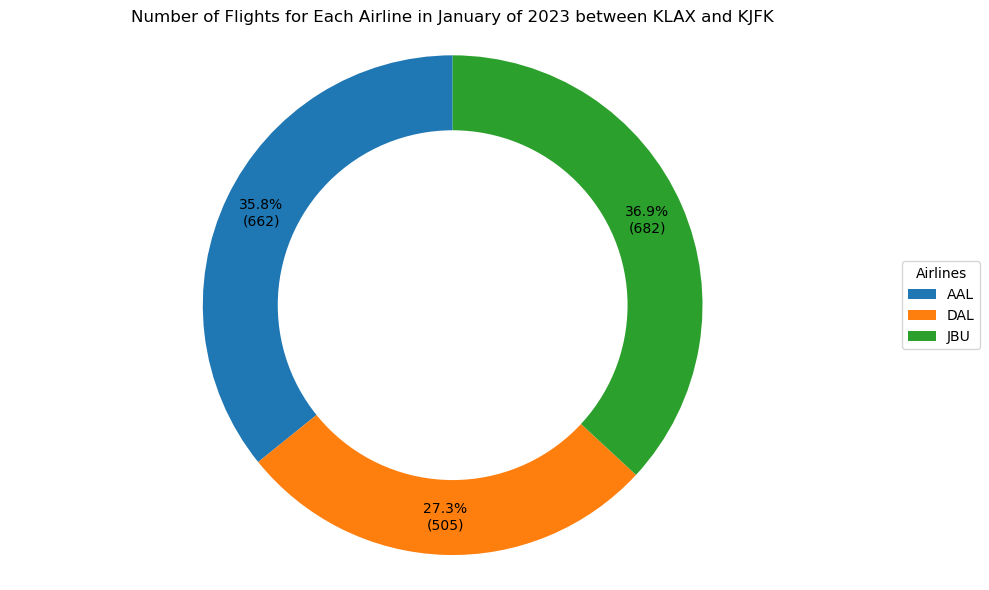

In [32]:
# Count the occurrences of each airline
airlines, counts = np.unique(flights['airline'], return_counts=True)

# Create a DataFrame from the data
data = pd.DataFrame({
    'Airlines': airlines,
    'Flight Counts': counts
})

# Creating the pie chart using the fig, ax approach
fig, ax = plt.subplots(figsize=(10, 6))

def custom_autopct(pct):
    total = sum(counts)
    val = int(round(pct*total/100.0))
    return '{p:.1f}%\n({v:d})'.format(p=pct,v=val) if pct > 3 else ''

wedges, texts, autotexts = ax.pie(data['Flight Counts'], autopct=custom_autopct,
                                   startangle=90, pctdistance=0.85)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Change the color and position of the percentage texts
for autotext in autotexts:
    autotext.set_color('black')

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# Create a legend
ax.legend(wedges, data['Airlines'], title="Airlines", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title(f'Number of Flights for Each Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Display the plot
plt.tight_layout()
fig.tight_layout()
plt.show()

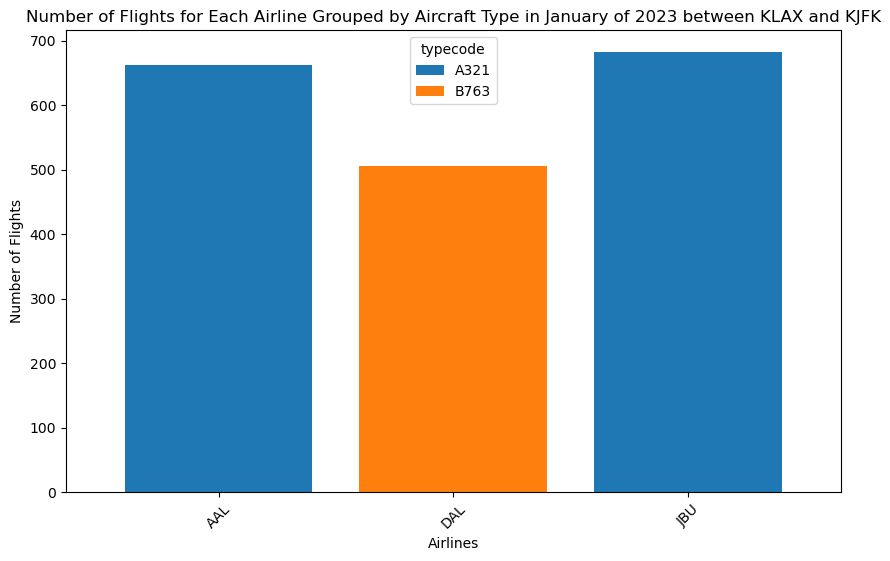

Done


In [33]:
# Count the occurrences of each airline
airlines, counts = np.unique(flights['airline'], return_counts=True)

aircrafts, counts = np.unique(flights['typecode'], return_counts=True)

# Group by airlines and aircraft type, then count
grouped_data = flights.groupby(['airline', 'typecode']).size().reset_index(name='counts')

# Pivot the data for plotting
pivot_data = grouped_data.pivot(index='airline', columns='typecode', values='counts').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
pivot_data.plot(kind='bar', stacked=True, ax=ax, width=0.8)
ax.set_title(f'Number of Flights for Each Airline Grouped by Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.set_xlabel('Airlines')
ax.set_ylabel('Number of Flights')
plt.xticks(rotation=45)

plt.show()

fig.tight_layout()

print("Done")


### Number of Flights by Aircraft

Done


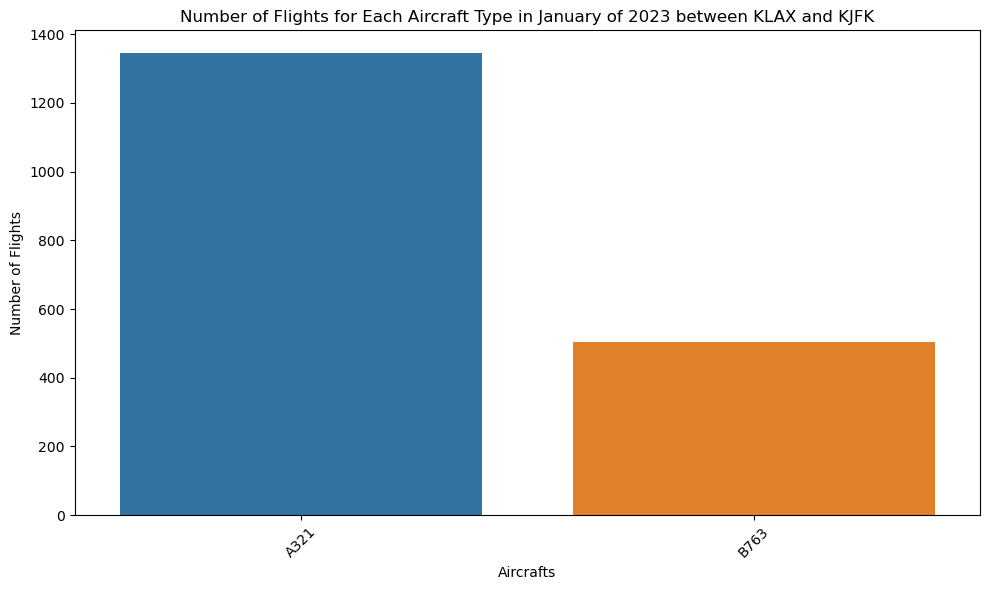

In [34]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

data = pd.DataFrame({
    'Aircrafts': aircrafts,
    'Flight Counts': counts_aircrafts
})

# Creating the plot using the fig, ax approach
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Aircrafts', y='Flight Counts', data=data, ax=ax)
ax.set_title(f'Number of Flights for Each Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.set_xlabel('Aircrafts')
ax.set_ylabel('Number of Flights')
plt.xticks(rotation=45)

fig.tight_layout()
print("Done")

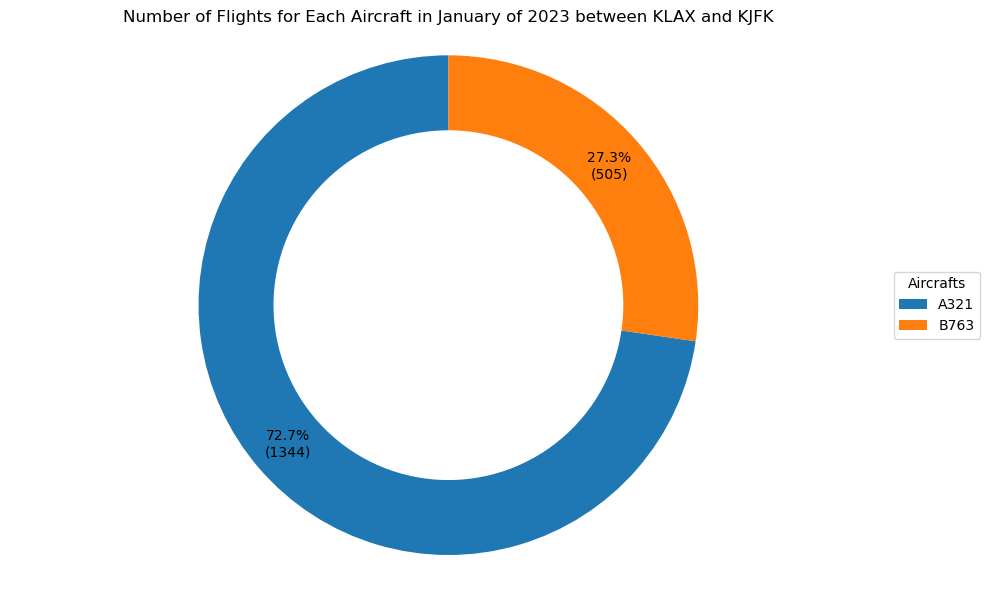

In [35]:
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Create a DataFrame from the data
data = pd.DataFrame({
    'Aircrafts': aircrafts,
    'Flight Counts': counts_aircrafts
})

# Creating the pie chart using the fig, ax approach
fig, ax = plt.subplots(figsize=(10, 6))

def custom_autopct(pct):
    total = sum(counts)
    val = int(round(pct*total/100.0))
    return '{p:.1f}%\n({v:d})'.format(p=pct,v=val) if pct > 3 else ''

wedges, texts, autotexts = ax.pie(data['Flight Counts'], autopct=custom_autopct,
                                   startangle=90, pctdistance=0.85)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Change the color and position of the percentage texts
for autotext in autotexts:
    autotext.set_color('black')

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# Create a legend
ax.legend(wedges, data['Aircrafts'], title="Aircrafts", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title(f'Number of Flights for Each Aircraft in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Display the plot
plt.tight_layout()
plt.show()

fig.tight_layout()


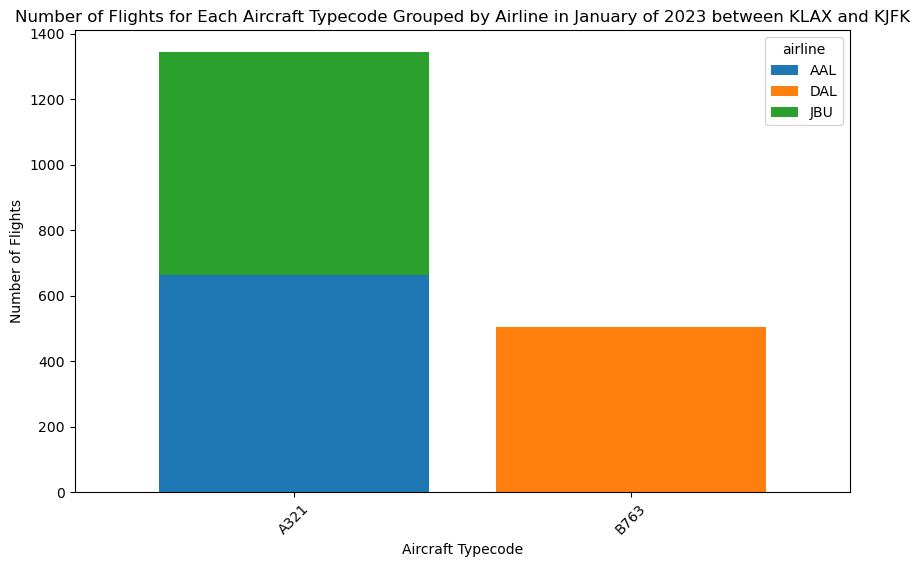

In [36]:
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Group by typecode and airline, then count
grouped_data = flights.groupby(['typecode', 'airline']).size().reset_index(name='counts')

# Pivot the data for plotting
pivot_data = grouped_data.pivot(index='typecode', columns='airline', values='counts').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
pivot_data.plot(kind='bar', stacked=True, ax=ax, width=0.8)
ax.set_title(f'Number of Flights for Each Aircraft Typecode Grouped by Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.set_xlabel('Aircraft Typecode')
ax.set_ylabel('Number of Flights')
plt.xticks(rotation=45)

plt.show()
fig.tight_layout()


## Fuel Consumption Analysis

### Fuel Consumption by Airline

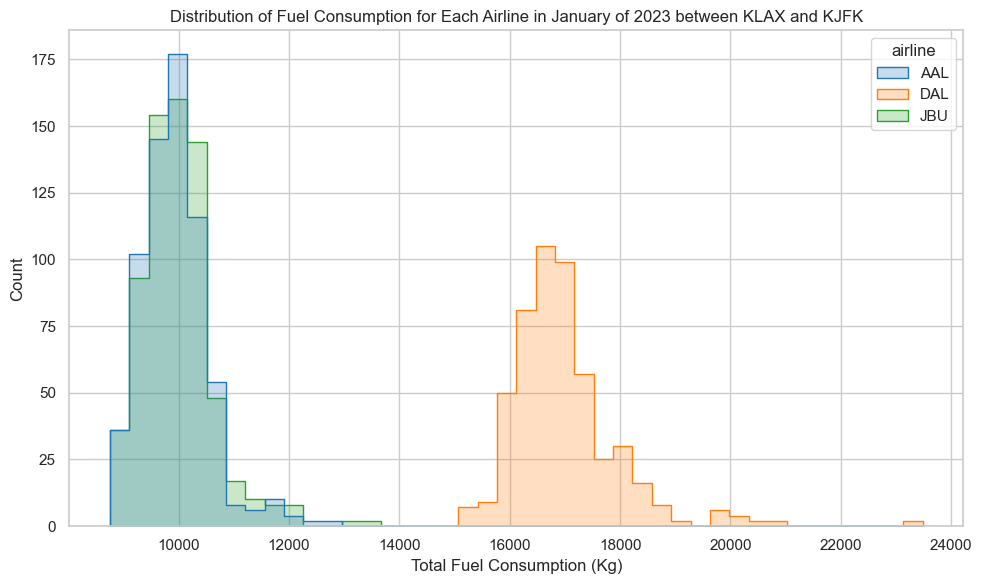

In [37]:
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Define the number of bins
bins = np.linspace(flights['fuel'].min(), flights['fuel'].max(), num=int(np.sqrt(len(flights))))

# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram using Seaborn
sns.histplot(data=flights, x='fuel', hue='airline', element='step', stat='count', common_norm=False, bins=bins, palette='tab10', ax=ax)

# Labeling the plot
ax.set_xlabel('Total Fuel Consumption (Kg)')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Fuel Consumption for Each Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show legend and plot
fig.tight_layout()

plt.show()

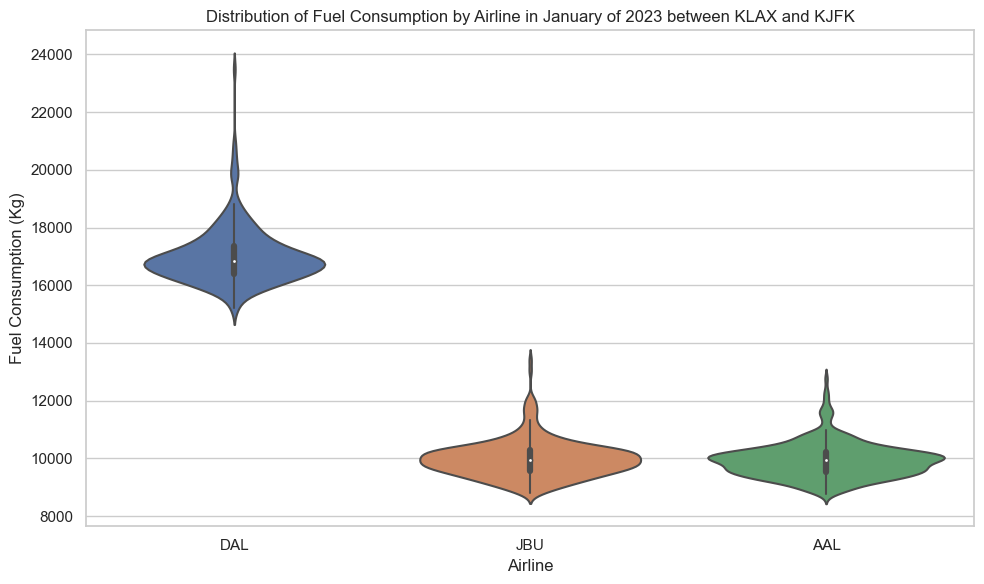

In [38]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Calculate average fuel consumption by airline
average_fuel_by_airline = flights.groupby('airline')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_airlines = average_fuel_by_airline.index.tolist()
flights_sorted = flights.set_index('airline').loc[sorted_airlines].reset_index()

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Retrieve the current color palette
current_palette = sns.color_palette()

# Create the violin plot using the axes object with sorted data
sns.violinplot(x='airline', y='fuel', data=flights_sorted, palette=current_palette, ax=ax, order=sorted_airlines)

# Labeling the plot
ax.set_xlabel('Airline')
ax.set_ylabel('Fuel Consumption (Kg)')
ax.set_title(f'Distribution of Fuel Consumption by Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show plot
fig.tight_layout()
plt.show()

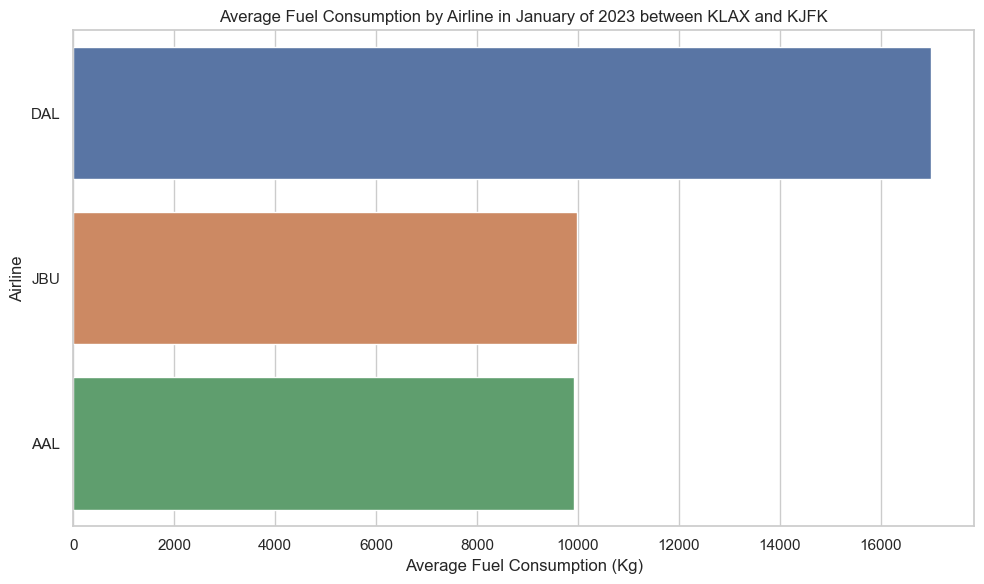

In [39]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Calculate average fuel consumption by airline
average_fuel_by_airline = flights.groupby('airline')['fuel'].mean().sort_values(ascending=False)

# Retrieve the current color palette
current_palette = sns.color_palette()

# Create a color dictionary for each airline to ensure consistent coloring
unique_airlines = average_fuel_by_airline.index
colors = {airline: current_palette[i % len(current_palette)] for i, airline in enumerate(unique_airlines)}
# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create the horizontal bar plot with consistent colors
sns.barplot(x=average_fuel_by_airline.values, y=average_fuel_by_airline.index, ax=ax, 
            palette=[colors[airline] for airline in average_fuel_by_airline.index])

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Airline')
ax.set_title(f'Average Fuel Consumption by Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show plot
fig.tight_layout()
plt.show()

### Fuel Consumption by Aircraft

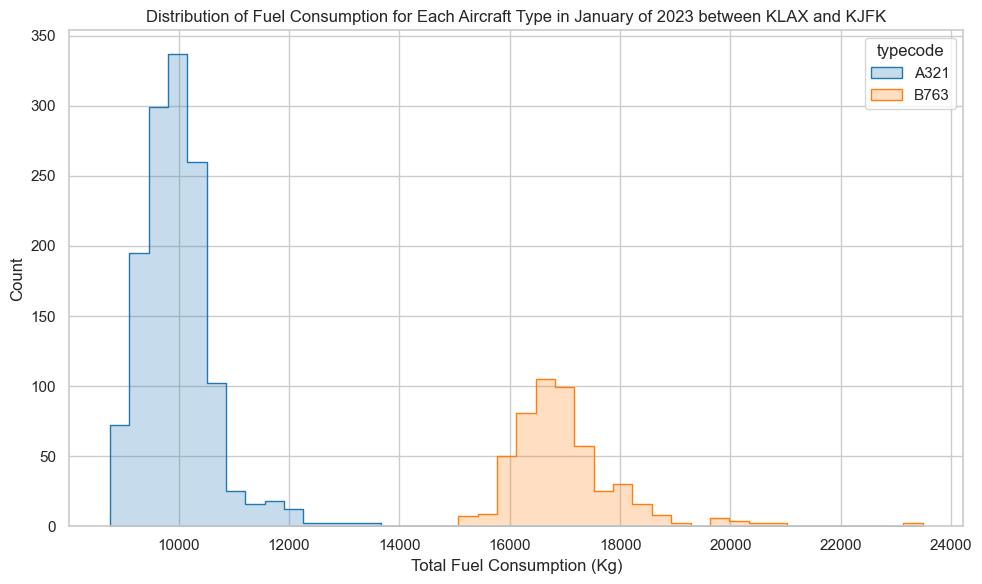

In [40]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Define the number of bins
bins = np.linspace(flights['fuel'].min(), flights['fuel'].max(), num=int(np.sqrt(len(flights))))

# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram using Seaborn
sns.histplot(data=flights, x='fuel', hue='typecode', element='step', stat='count', common_norm=False, bins=bins, palette='tab10', ax=ax)

# Labeling the plot
ax.set_xlabel('Total Fuel Consumption (Kg)')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Fuel Consumption for Each Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show legend and plot
fig.tight_layout()

plt.show()

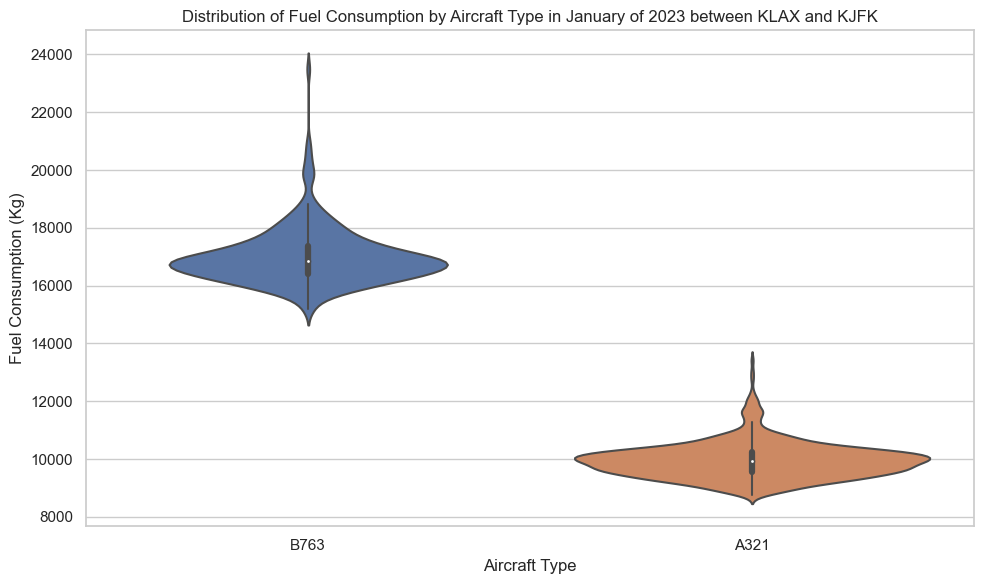

In [41]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Calculate average fuel consumption by aircraft type
average_fuel_by_aircraft = flights.groupby('typecode')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order of aircraft types
sorted_aircrafts = average_fuel_by_aircraft.index.tolist()
flights_sorted = flights.set_index('typecode').loc[sorted_aircrafts].reset_index()

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Retrieve the current color palette
current_palette = sns.color_palette()

# Create the violin plot using the axes object with sorted data
sns.violinplot(x='typecode', y='fuel', data=flights_sorted, palette=current_palette, ax=ax, order=sorted_aircrafts)

# Labeling the plot
ax.set_xlabel('Aircraft Type')
ax.set_ylabel('Fuel Consumption (Kg)')
ax.set_title(f'Distribution of Fuel Consumption by Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show plot
fig.tight_layout()
plt.show()

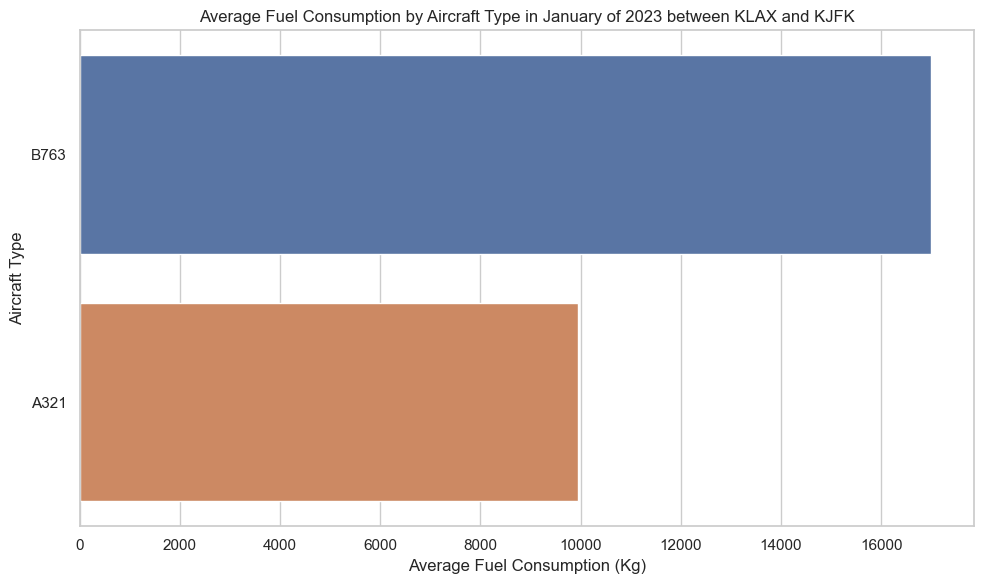

In [42]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Calculate average fuel consumption by aircraft
average_fuel_by_aircraft = flights.groupby('typecode')['fuel'].mean().sort_values(ascending=False)

# Retrieve the current color palette
current_palette = sns.color_palette()

# Create a color dictionary for each aircraft to ensure consistent coloring
unique_aircrafts = average_fuel_by_aircraft.index
colors = {airline: current_palette[i % len(current_palette)] for i, airline in enumerate(unique_aircrafts)}
# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create the horizontal bar plot with consistent colors
sns.barplot(x=average_fuel_by_aircraft.values, y=average_fuel_by_aircraft.index, ax=ax, 
            palette=[colors[aircraft] for aircraft in average_fuel_by_aircraft.index])

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Aircraft Type')
ax.set_title(f'Average Fuel Consumption by Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')

# Show plot
fig.tight_layout()
plt.show()

## Fuel Consumption Vs Time

### Fuel Consumption Vs Time By Airline

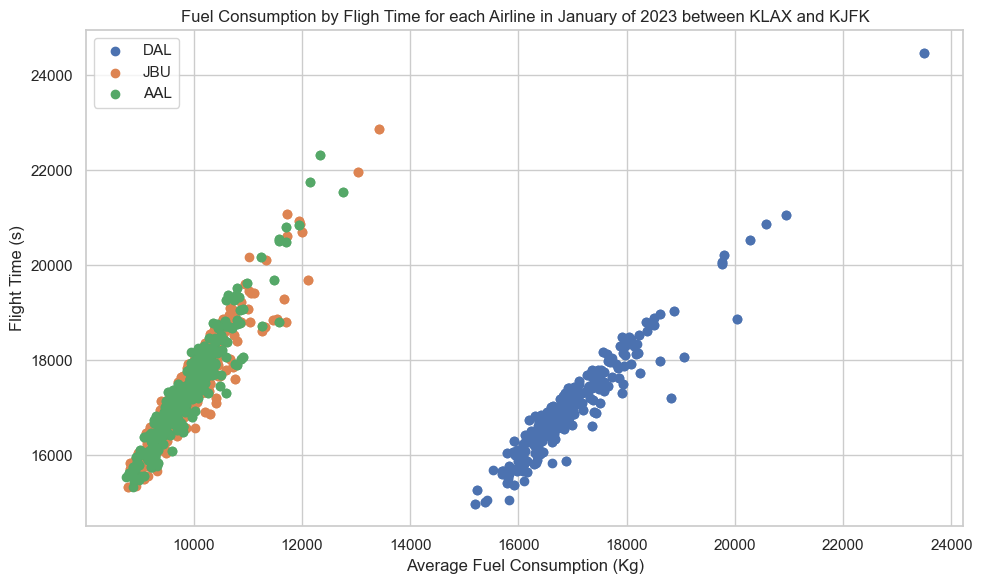

In [43]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Calculate average fuel consumption by airline
average_fuel_by_airline = flights.groupby('airline')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_airlines = average_fuel_by_airline.index.tolist()
flights_sorted = flights.set_index('airline').loc[sorted_airlines].reset_index()

fig, ax = plt.subplots(figsize = (10, 6))
for airline in sorted_airlines:
    mask = flights['airline'] == airline
    ax.scatter(flights[mask]['fuel'], flights[mask]['time'], label=airline)

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Flight Time (s)')
ax.set_title(f'Fuel Consumption by Fligh Time for each Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.legend()
# Show plot
fig.tight_layout()
plt.show()

### Fuel Consumption Vs Time By Aircraft

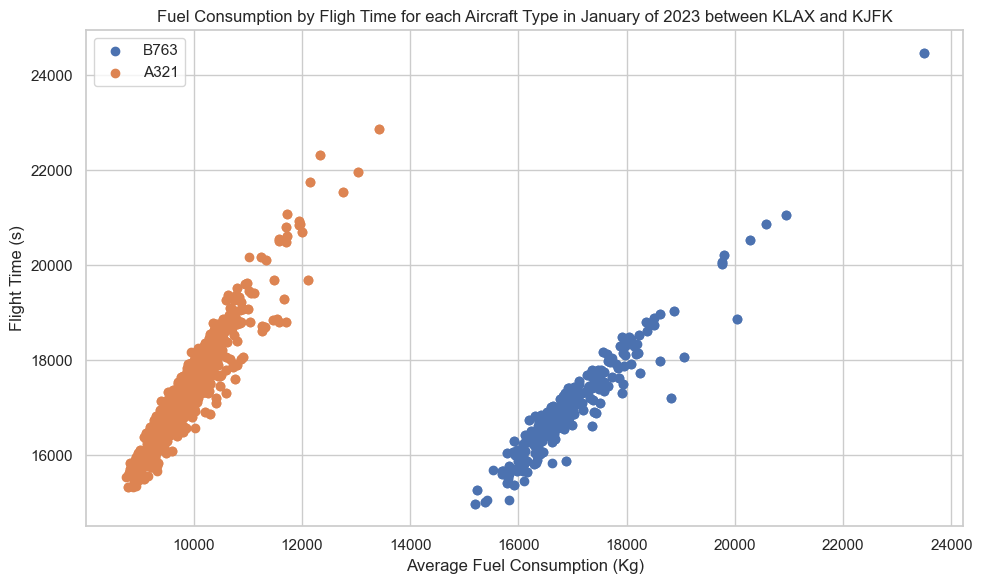

In [44]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Calculate average fuel consumption by airline
average_fuel_by_aircraft = flights.groupby('typecode')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_aircrafts = average_fuel_by_aircraft.index.tolist()
flights_sorted = flights.set_index('typecode').loc[sorted_aircrafts].reset_index()

fig, ax = plt.subplots(figsize = (10, 6))
for aircraft in sorted_aircrafts:
    mask = flights['typecode'] == aircraft
    ax.scatter(flights[mask]['fuel'], flights[mask]['time'], label=aircraft)

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Flight Time (s)')
ax.set_title(f'Fuel Consumption by Fligh Time for each Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.legend()
# Show plot
fig.tight_layout()
plt.show()

## Fuel Consumption Vs Distance

### Fuel Consumption Vs Distance By Airline

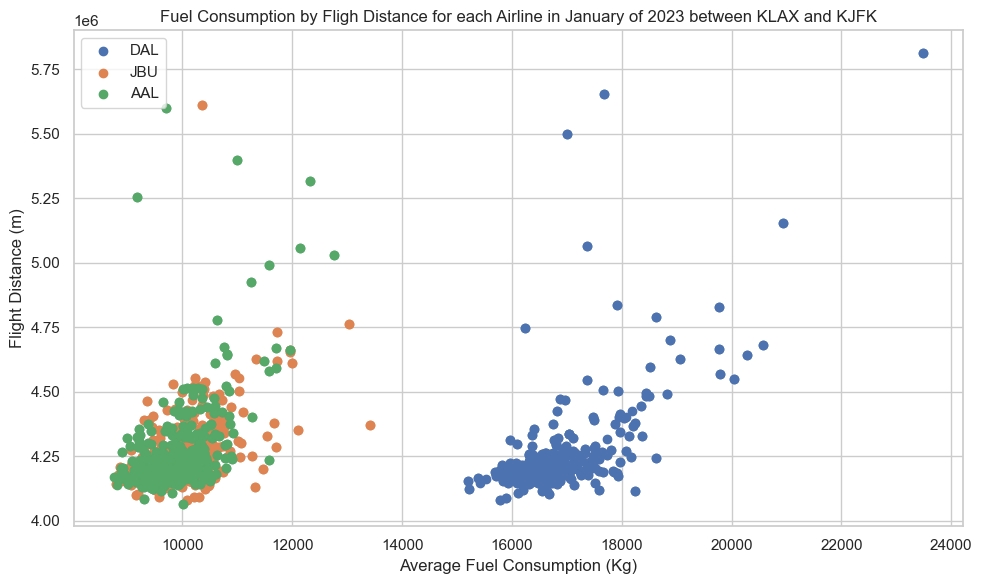

In [45]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Calculate average fuel consumption by airline
average_fuel_by_airline = flights.groupby('airline')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_airlines = average_fuel_by_airline.index.tolist()
flights_sorted = flights.set_index('airline').loc[sorted_airlines].reset_index()

fig, ax = plt.subplots(figsize = (10, 6))
for airline in sorted_airlines:
    mask = flights['airline'] == airline
    ax.scatter(flights[mask]['fuel'], flights[mask]['distance'], label=airline)

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Flight Distance (m)')
ax.set_title(f'Fuel Consumption by Fligh Distance for each Airline in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.legend()
# Show plot
fig.tight_layout()
plt.show()

### Fuel Consumption Vs Distance By Airline

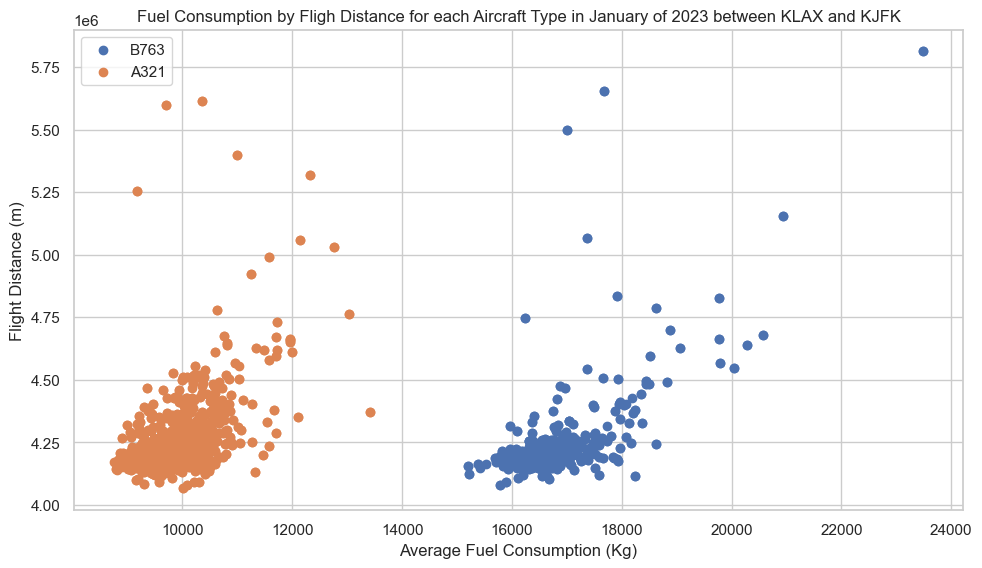

In [48]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

# Calculate average fuel consumption by airline
average_fuel_by_aircraft = flights.groupby('typecode')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_aircrafts = average_fuel_by_aircraft.index.tolist()
flights_sorted = flights.set_index('typecode').loc[sorted_aircrafts].reset_index()

fig, ax = plt.subplots(figsize = (10, 6))
for aircraft in sorted_aircrafts:
    mask = flights['typecode'] == aircraft
    ax.scatter(flights[mask]['fuel'], flights[mask]['distance'], label=aircraft)

# Labeling the plot
ax.set_xlabel('Average Fuel Consumption (Kg)')
ax.set_ylabel('Flight Distance (m)')
ax.set_title(f'Fuel Consumption by Fligh Distance for each Aircraft Type in {month} of 2023 between {departure_airport} and {arrival_airport}')
ax.legend()
#ax.set_ylim([1.5e6, 1.9e6])

# Show plot
fig.tight_layout()
plt.show()

## Weather Integrals

### Optimal Vs Actual

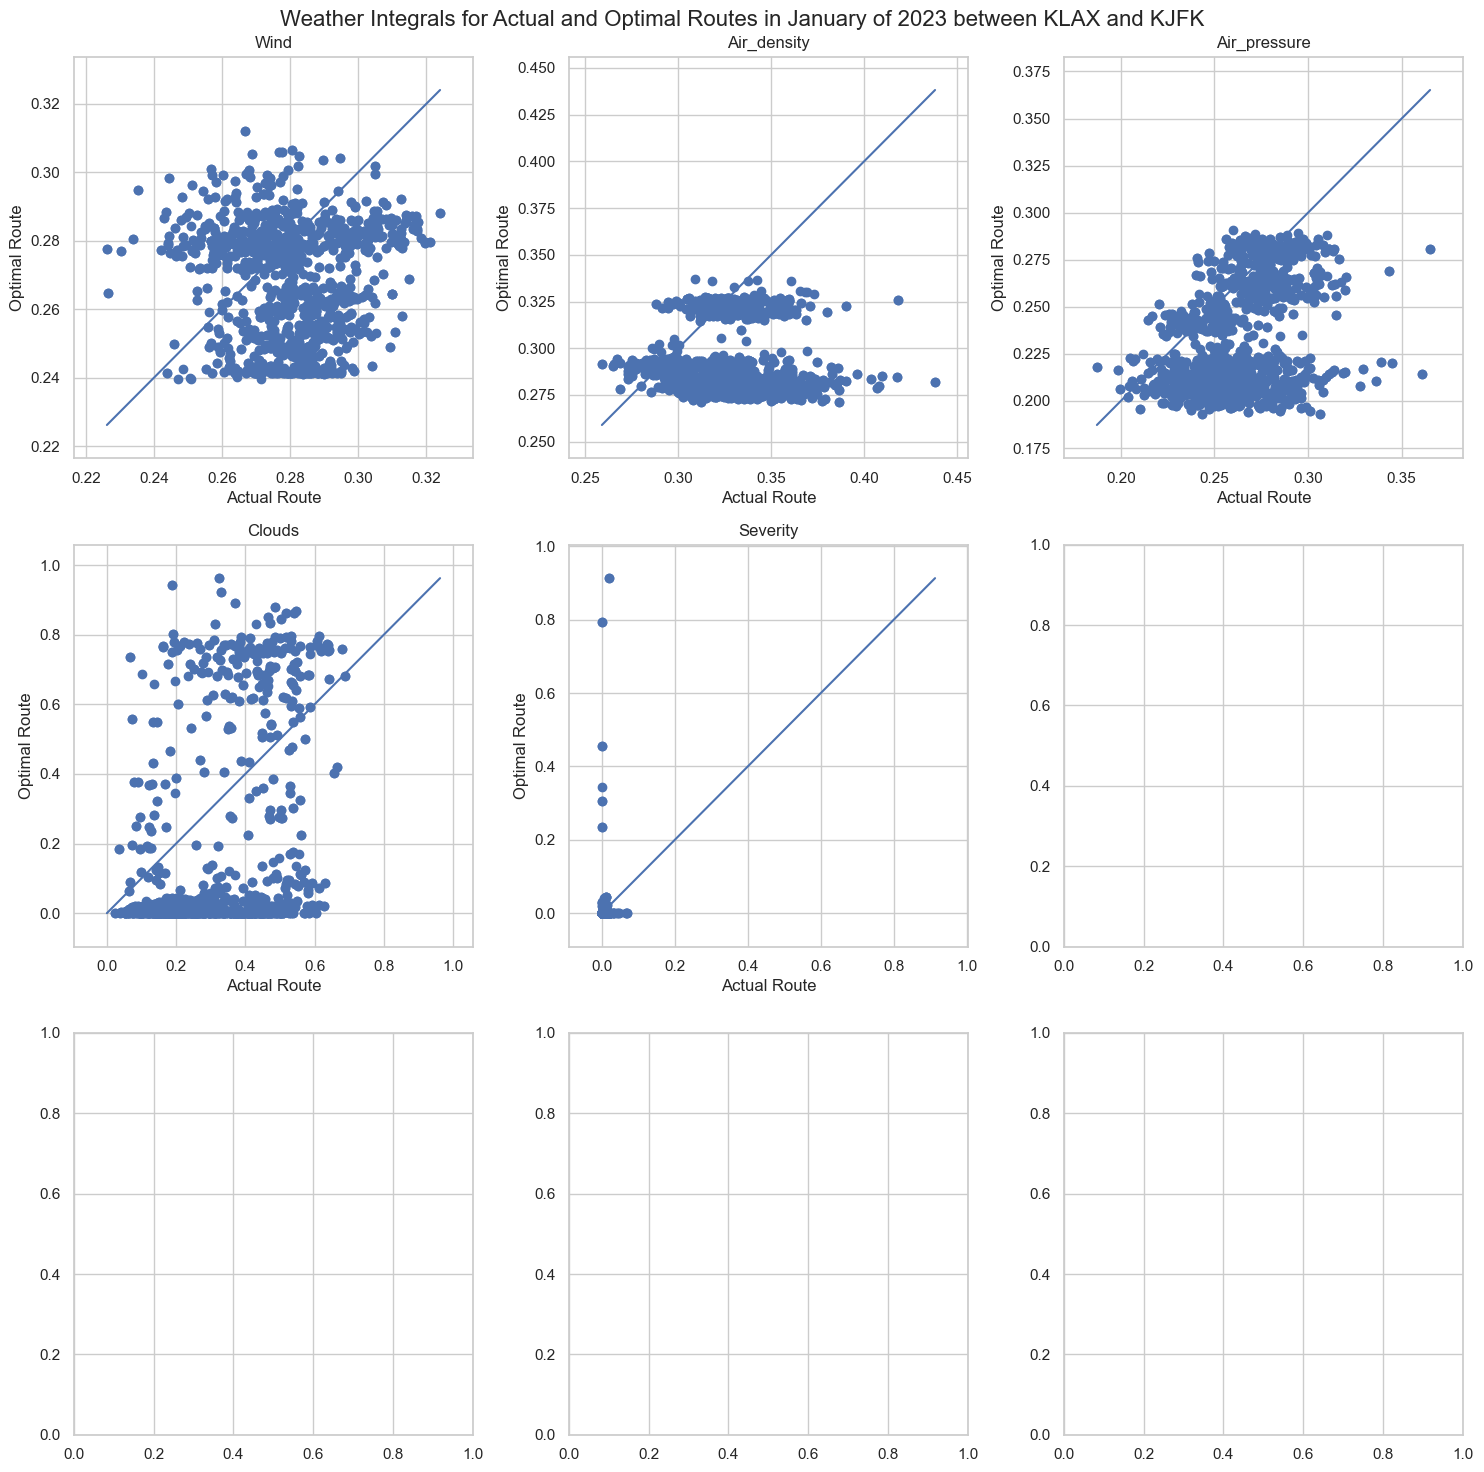

In [49]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

columns = ['wind', 'air_density', 'air_pressure', 'clouds', 'severity']
opt_columns = ['opt_'+col for col in columns]

grid_size = math.ceil(np.sqrt(len(columns)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*5, grid_size*5))
axes = axes.flatten()
for i, col, opt_col in zip(range(len(columns)), columns, opt_columns):
    ax = axes[i]
    minX = min([flights[col].min(), flights[opt_col].min()])
    maxX = max([flights[col].max(), flights[opt_col].max()])
    rangeX = maxX - minX
    ax.scatter(flights[col], flights[opt_col])
    ax.plot([minX, maxX], [minX, maxX])
    ax.set_xlabel('Actual Route')
    ax.set_ylabel('Optimal Route')
    ax.set_title(f'{col[0].upper()}{col[1:]}')

    ax.set_xlim([minX - rangeX*0.1, maxX + rangeX*0.1])
    ax.set_ylim([minX - rangeX*0.1, maxX + rangeX*0.1])
    
fig.suptitle(f'Weather Integrals for Actual and Optimal Routes in {month} of 2023 between {departure_airport} and {arrival_airport}', fontsize=16)

fig.tight_layout()

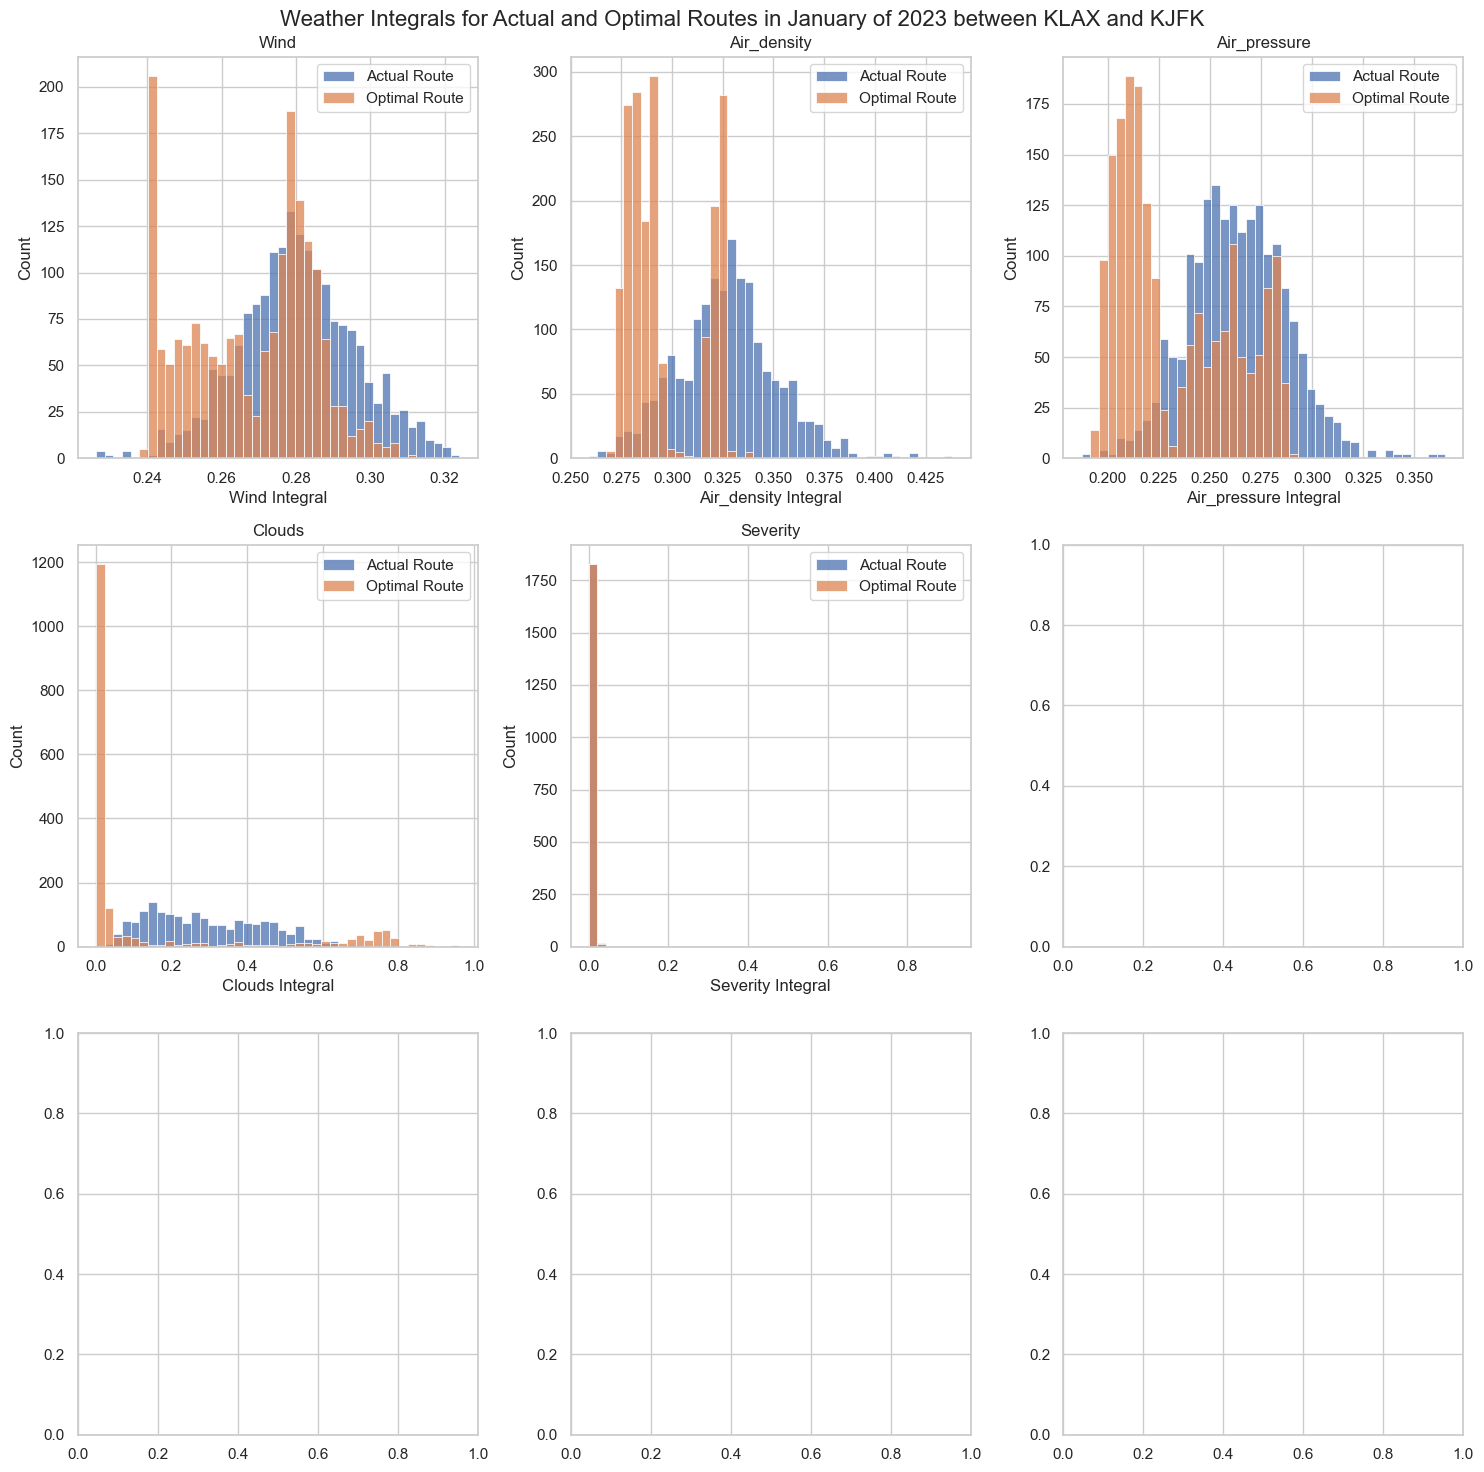

In [50]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

columns = ['wind', 'air_density', 'air_pressure', 'clouds', 'severity']
opt_columns = ['opt_'+col for col in columns]

grid_size = math.ceil(np.sqrt(len(columns)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*5, grid_size*5))
axes = axes.flatten()
for i, col, opt_col in zip(range(len(columns)), columns, opt_columns):
    ax = axes[i]
    minX = min([flights[col].min(), flights[opt_col].min()])
    maxX = max([flights[col].max(), flights[opt_col].max()])
    rangeX = maxX - minX
    bins = np.linspace(minX, maxX, num=int(np.sqrt(len(flights))))
    sns.histplot(flights[col], bins=bins, kde=False, label='Actual Route', ax=ax)
    sns.histplot(flights[opt_col], bins=bins, kde=False, label='Optimal Route', ax=ax)
    
    
    ax.set_xlabel(f'{col[0].upper()}{col[1:]} Integral')
    ax.set_ylabel('Count')
    ax.set_title(f'{col[0].upper()}{col[1:]}')
    ax.legend()
    
fig.suptitle(f'Weather Integrals for Actual and Optimal Routes in {month} of 2023 between {departure_airport} and {arrival_airport}', fontsize=16)

fig.tight_layout()

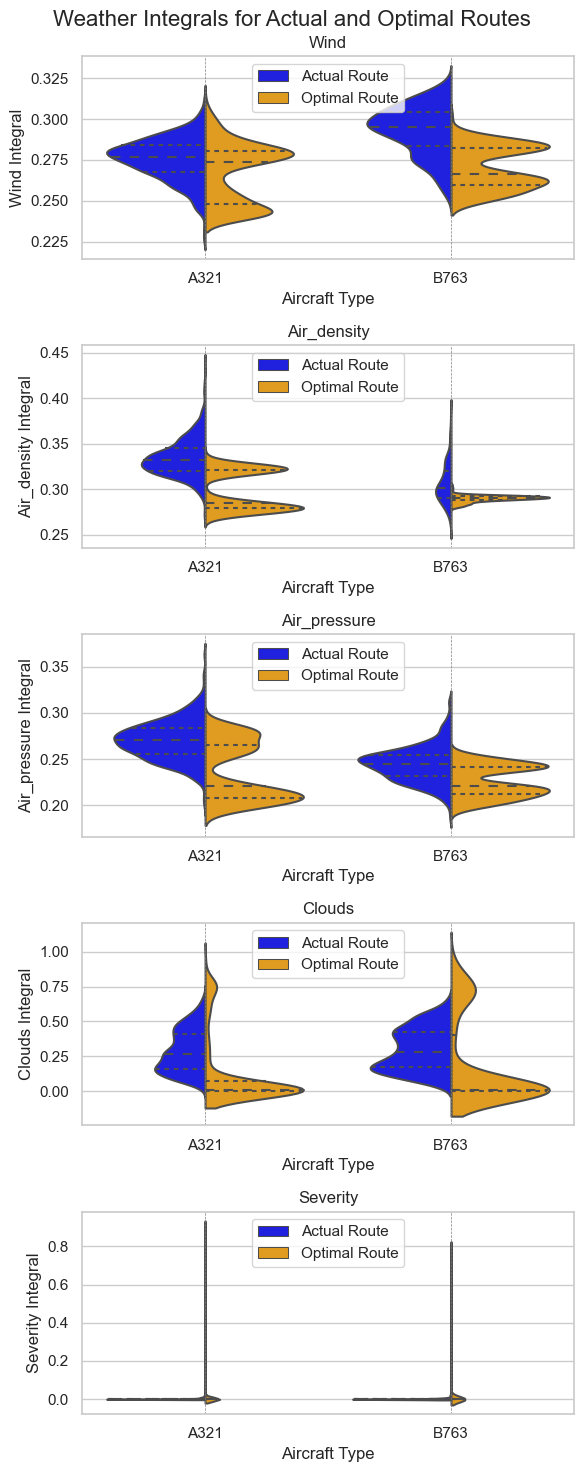

In [51]:
df_melted = pd.melt(flights,
                    id_vars='typecode',
                    value_vars=columns + opt_columns,
                    var_name='condition',
                    value_name='value')
condition_mapping = {**{col: 'Actual Route' for col in columns}, **{opt_col: 'Optimal Route' for opt_col in opt_columns}}
df_melted['Route'] = df_melted['condition'].map(condition_mapping)

# Create a mapping from each column name to the route type ('Actual' or 'Optimal')
route_type_mapping = {col: 'Actual Route' for col in columns}
route_type_mapping.update({'opt_' + col: 'Optimal Route' for col in columns})

# Apply this mapping to create a new 'Route Type' column for coloring
df_melted['Route Type'] = df_melted['condition'].map(route_type_mapping)

# Now plot the violin plots
fig, axes = plt.subplots(len(columns), figsize=(len(np.unique(flights['typecode']))*3, len(columns)*3))

for i, col in enumerate(columns):
    # Filter the data for the current column and its optimal counterpart
    df_violin = df_melted[(df_melted['condition'] == col) | (df_melted['condition'] == 'opt_' + col)].copy()
    
    # Map the 'condition' to 'Actual' or 'Optimal'
    df_violin['Route Type'] = df_violin['condition'].map(lambda x: 'Actual Route' if x == col else 'Optimal Route')
    
    # Plot split violinplot
    sns.violinplot(data=df_violin, x='typecode', y='value', hue='Route Type', split=True,
               inner='quart', linewidth=1.5, palette={'Actual Route': 'blue', 'Optimal Route': 'orange'},
               density_norm='width',  # Updated parameter as per the warning
               ax=axes[i])
    
    # Get the current x-axis tick locations which should correspond to the 'typecode' categories
    xticks = axes[i].get_xticks()
    
    # Draw a vertical line at each x-axis tick location to separate the blue and orange sides
    for x in xticks:
        axes[i].axvline(x=x, color='grey', linestyle='--', lw=0.5)
    # Set the aesthetics for the plot
    axes[i].set_xlabel('Aircraft Type')
    axes[i].set_ylabel(f'{col.capitalize()} Integral')
    axes[i].set_title(f'{col.capitalize()}')

    axes[i].legend()

# Adjust the layout
plt.suptitle('Weather Integrals for Actual and Optimal Routes', fontsize=16)
fig.tight_layout()  # Adjust the rectangle in which to fit the subplots
plt.show()

# Models Optimization for Fuel Consumption and Weather Inflience Score

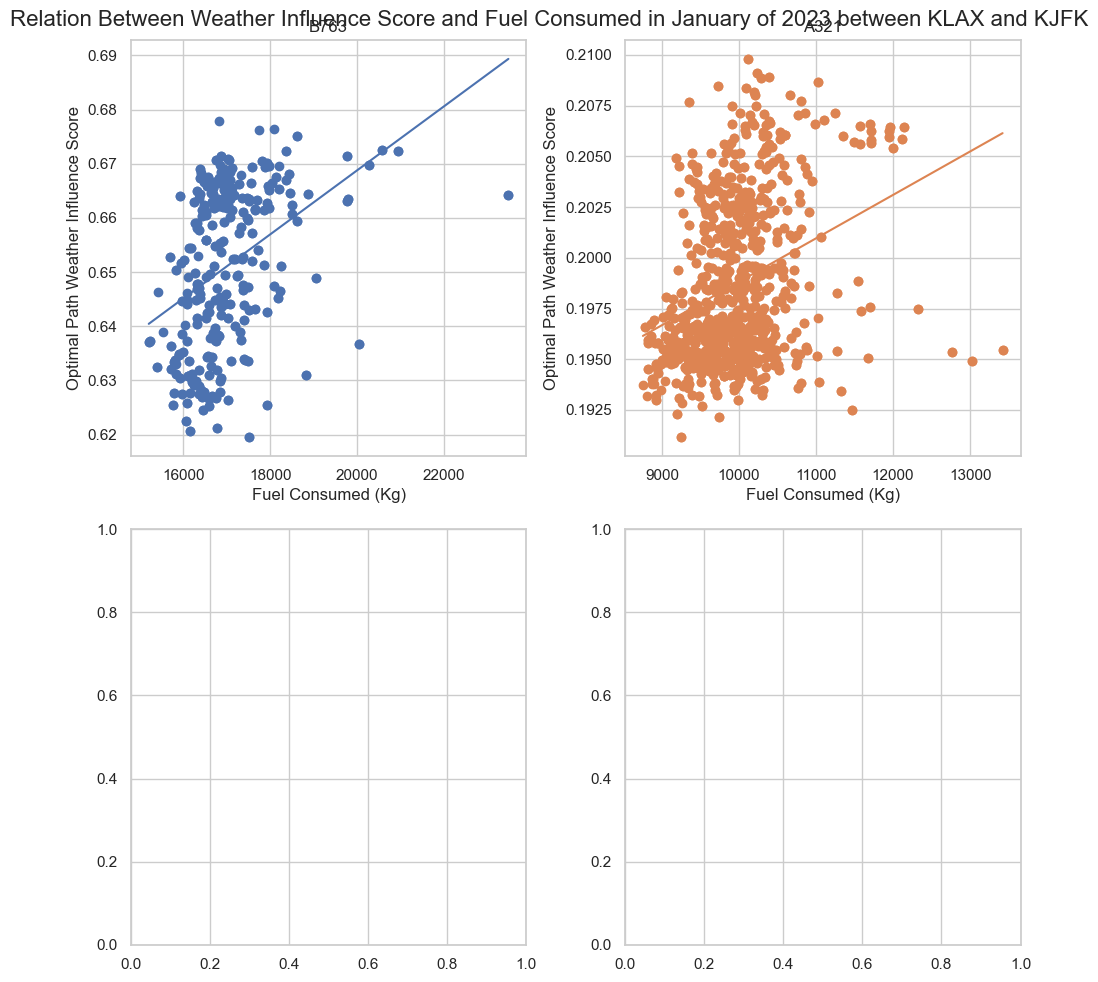

In [52]:
# Count the occurrences of each airline
airlines, counts_airlines = np.unique(flights['airline'], return_counts=True)
aircrafts, counts_aircrafts = np.unique(flights['typecode'], return_counts=True)

columns = ['wind', 'air_density', 'air_pressure', 'clouds', 'severity']
# columns = ['wind', 'air_pressure', 'clouds']
opt_columns = ['opt_'+col for col in columns]
scaled_columns = [col + '_scaled' for col in columns]
opt_scaled_columns = [col + '_scaled' for col in opt_columns]

# Calculate average fuel consumption by airline
average_fuel_by_aircraft = flights.groupby('typecode')['fuel'].mean().sort_values(ascending=False)

# Sort the 'flights' DataFrame based on the average fuel consumption order
sorted_aircrafts = average_fuel_by_aircraft.index.tolist()
flights_sorted = flights.set_index('typecode').loc[sorted_aircrafts].reset_index()

# Retrieve the current color palette
current_palette = sns.color_palette()

# Create a color dictionary for each aircraft to ensure consistent coloring
unique_aircrafts = average_fuel_by_aircraft.index
colors = {airline: current_palette[i % len(current_palette)] for i, airline in enumerate(unique_aircrafts)}

n_aircrafts = len(sorted_aircrafts)
# Determine the number of rows and columns for the square (or nearly square) grid
grid_size = math.ceil(np.sqrt(n_aircrafts))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*5, grid_size*5))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, aircraft in enumerate(sorted_aircrafts):
    if i >= len(axes):  # In case of more aircraft types than grid cells
        break

    ax = axes[i]
    mask = flights['typecode'] == aircraft
    flights_aircraft = flights[mask].copy()
    X = flights_aircraft[opt_columns]
    y = flights_aircraft['fuel']

    # Define the objective function: sum of squared residuals
    def objective_function(coeffs):
        predictions = X.dot(coeffs[:-1]) + coeffs[-1]  # Last coefficient is the intercept
        residuals = y - predictions
        return sum(residuals**2)

    # Define bounds for the coefficients
    bounds = []
    for col in opt_columns:
        if col in ['opt_wind', 'clouds', 'opt_severity']:
            bounds.append((None, None))  # Strictly positive
        elif col in ['opt_air_density', 'opt_air_pressure']:
            bounds.append((None, None))  # Strictly negative
        else:
            bounds.append((None, None))  # No bounds

    # Add bounds for the intercept (last coefficient)
    bounds.append((None, None))

    # Initial guess for coefficients
    initial_guess = [0] * (len(opt_columns) + 1)

    # Perform the optimization
    result = minimize(objective_function, initial_guess, bounds=bounds)
    
    norm = np.sqrt(np.sum(result.x**2))
    # Extract coefficients
    coefficients = {col:result.x[i]/norm for i, col in enumerate(opt_columns)}
    coefficients['const'] = result.x[-1]/norm
    for col, opt_col in zip(columns, opt_columns):
        flights_aircraft[col+'_coef'] = coefficients[opt_col]
        flights_aircraft[col+'_scaled'] = flights_aircraft[col] * coefficients[opt_col]
        flights_aircraft[opt_col+'_scaled'] = flights_aircraft[opt_col] * coefficients[opt_col]
        
    flights_aircraft['const_coef'] = coefficients['const']
        
    flights_aircraft['weather_influence_score'] = flights_aircraft[scaled_columns].sum(axis=1) + coefficients['const']
    flights_aircraft['weather_influence_score_opt'] = flights_aircraft[opt_scaled_columns].sum(axis=1) + coefficients['const']
    
    m, b = np.polyfit(flights_aircraft['fuel'], flights_aircraft['weather_influence_score_opt'], 1)
    
    xs = np.linspace(min(flights_aircraft['fuel']), max(flights_aircraft['fuel']), num=100)
    ys = m*xs + b
    
    ax.scatter(flights_aircraft['fuel'], flights_aircraft['weather_influence_score_opt'], label=aircraft, color=colors[aircraft])
    ax.plot(xs, ys, color=colors[aircraft])
    ax.set_xlabel('Fuel Consumed (Kg)')
    ax.set_ylabel('Optimal Path Weather Influence Score')
    ax.set_title(aircraft)

    flights.loc[flights_aircraft.index, 'weather_influence_score'] = flights_aircraft['weather_influence_score']
    flights.loc[flights_aircraft.index, 'weather_influence_score_opt'] = flights_aircraft['weather_influence_score_opt']
    
    for col, opt_col in zip(columns, opt_columns):
        flights.loc[flights_aircraft.index, col+'_coef'] = flights_aircraft[col+'_coef']
        
    flights.loc[flights_aircraft.index, 'const_coef'] = flights_aircraft['const_coef']
    
    
        
# Add a global title
fig.suptitle(f'Relation Between Weather Influence Score and Fuel Consumed in {month} of 2023 between {departure_airport} and {arrival_airport}', fontsize=16)

# # Hide any unused subplots
# for j in range(i+1, len(axes)):
#     axes[j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top to make room for the global title
plt.show()
fig.tight_layout()

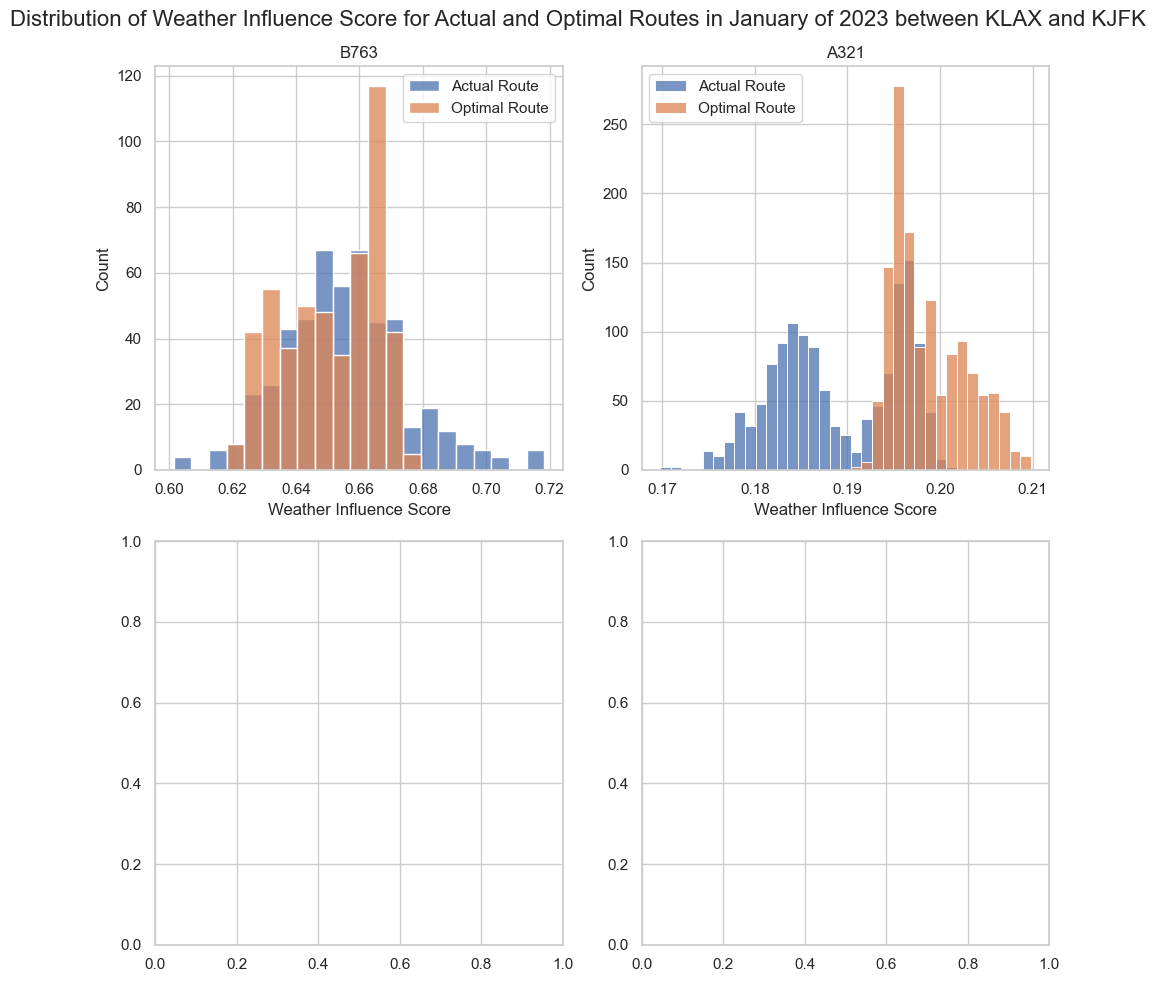

In [55]:
grid_size = math.ceil(np.sqrt(n_aircrafts))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*5, grid_size*5))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, aircraft in enumerate(sorted_aircrafts):
    if i >= len(axes):  # In case of more aircraft types than grid cells
        break
    mask = flights['typecode'] == aircraft
    flights_aircraft = flights[mask].copy()
    minX = min([flights_aircraft['weather_influence_score'].min(), flights_aircraft['weather_influence_score_opt'].min()])
    maxX = max([flights_aircraft['weather_influence_score'].max(), flights_aircraft['weather_influence_score_opt'].max()])
    bins = np.linspace(minX, maxX, num=int(np.sqrt(len(flights_aircraft))))
#     axes[i].hist(flights_aircraft['weather_influence_score'], histtype = 'step', label = 'Actual Route', bins=bins)
#     axes[i].hist(flights_aircraft['weather_influence_score_opt'], histtype = 'step', label = 'Optimal Route', bins=bins)
    try:
        sns.histplot(flights_aircraft['weather_influence_score'], bins=bins, kde=False, label='Actual Route', ax=axes[i])
        sns.histplot(flights_aircraft['weather_influence_score_opt'], bins=bins, kde=False, label='Optimal Route', ax=axes[i])
    except:
        pass
    axes[i].legend()
    axes[i].set_xlabel('Weather Influence Score')
    axes[i].set_ylabel('Count')
    axes[i].set_title(aircraft)
    
fig.suptitle(f'Distribution of Weather Influence Score for Actual and Optimal Routes in {month} of 2023 between {departure_airport} and {arrival_airport}', fontsize=16)

plt.tight_layout()
fig.tight_layout()
# plt.subplots_adjust(top=0.95)  # Adjust the top to make room for the global title
plt.show()
    

# plt.tight_layout()

In [108]:
flights.drop_duplicates(subset=['flight_id'], inplace=True)

# Splitting data for many ML models

In [141]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import kstest
import scipy.stats as stats
from sklearn.model_selection import learning_curve
X_dict = {}
y_dict = {}
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

for aircraft in aircrafts:
    aricraft_mask = flights['typecode'] == aircraft
    X = flights[aricraft_mask][['wind', 'air_density', 'air_pressure', 'clouds', 'severity']]
    #X = (X - X.min())/(X.max() - X.min())
    y = flights[aricraft_mask]['fuel']
    #y = (y - y.min())/(y.max() - y.min())

    # Spliting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_dict[aircraft] = X.copy()
    y_dict[aircraft] = y.copy()
    X_train_dict[aircraft] = X_train.copy()
    X_test_dict[aircraft] = X_test.copy()
    y_train_dict[aircraft] = y_train.copy()
    y_test_dict[aircraft] = y_test.copy()


In [170]:
y_train_dict[aircraft].values

array([ 9937.48949133,  9291.43507838, 10089.51239332,  9129.48328669,
       10023.3014342 , 10078.55725576, 10544.01811654, 10145.09638431,
        9720.79571461,  9380.88124277,  9188.09164375,  9728.55111261,
       10187.43403217, 10238.86526509,  9563.30682574,  9570.3743689 ,
       10172.86083965, 10359.88771539,  9953.89204934,  9483.10763014,
       10353.02317654, 11059.83646044, 10325.39139141, 10575.77742148,
        9930.76755664,  9341.52944414, 10208.3214901 ,  8900.51432628,
        9903.34839537,  9638.63694679,  8822.19133603,  9137.65988593,
       10179.40083183,  9905.3209983 ,  9864.63947692, 10195.06617384,
        9828.48951631,  8925.97799024, 10013.90840104, 10078.47428599,
        9610.1421837 , 10767.31042071, 10672.76245049,  9375.60290552,
       10427.77224024, 10312.75245149, 10329.49219193, 10182.83266745,
        9265.67982815,  9602.59953514,  9291.23145837, 10569.65335804,
       10352.20598587, 10003.26329455,  8952.49791359,  9830.95741056,
      

# Linear Regression

---------A321---------
R-squared: 0.21888690889953755
Mean Squared Error: 1.0480276006832296
Root mean squared error: 1.0237321918759954
KS Statistic: 0.15384615384615385
P-value: 0.5741562429811664
----------------------
---------B763---------
R-squared: 0.19810953672047393
Mean Squared Error: 0.569827401454929
Root mean squared error: 0.7548691286937949
KS Statistic: 0.15384615384615385
P-value: 0.5741562429811664
----------------------


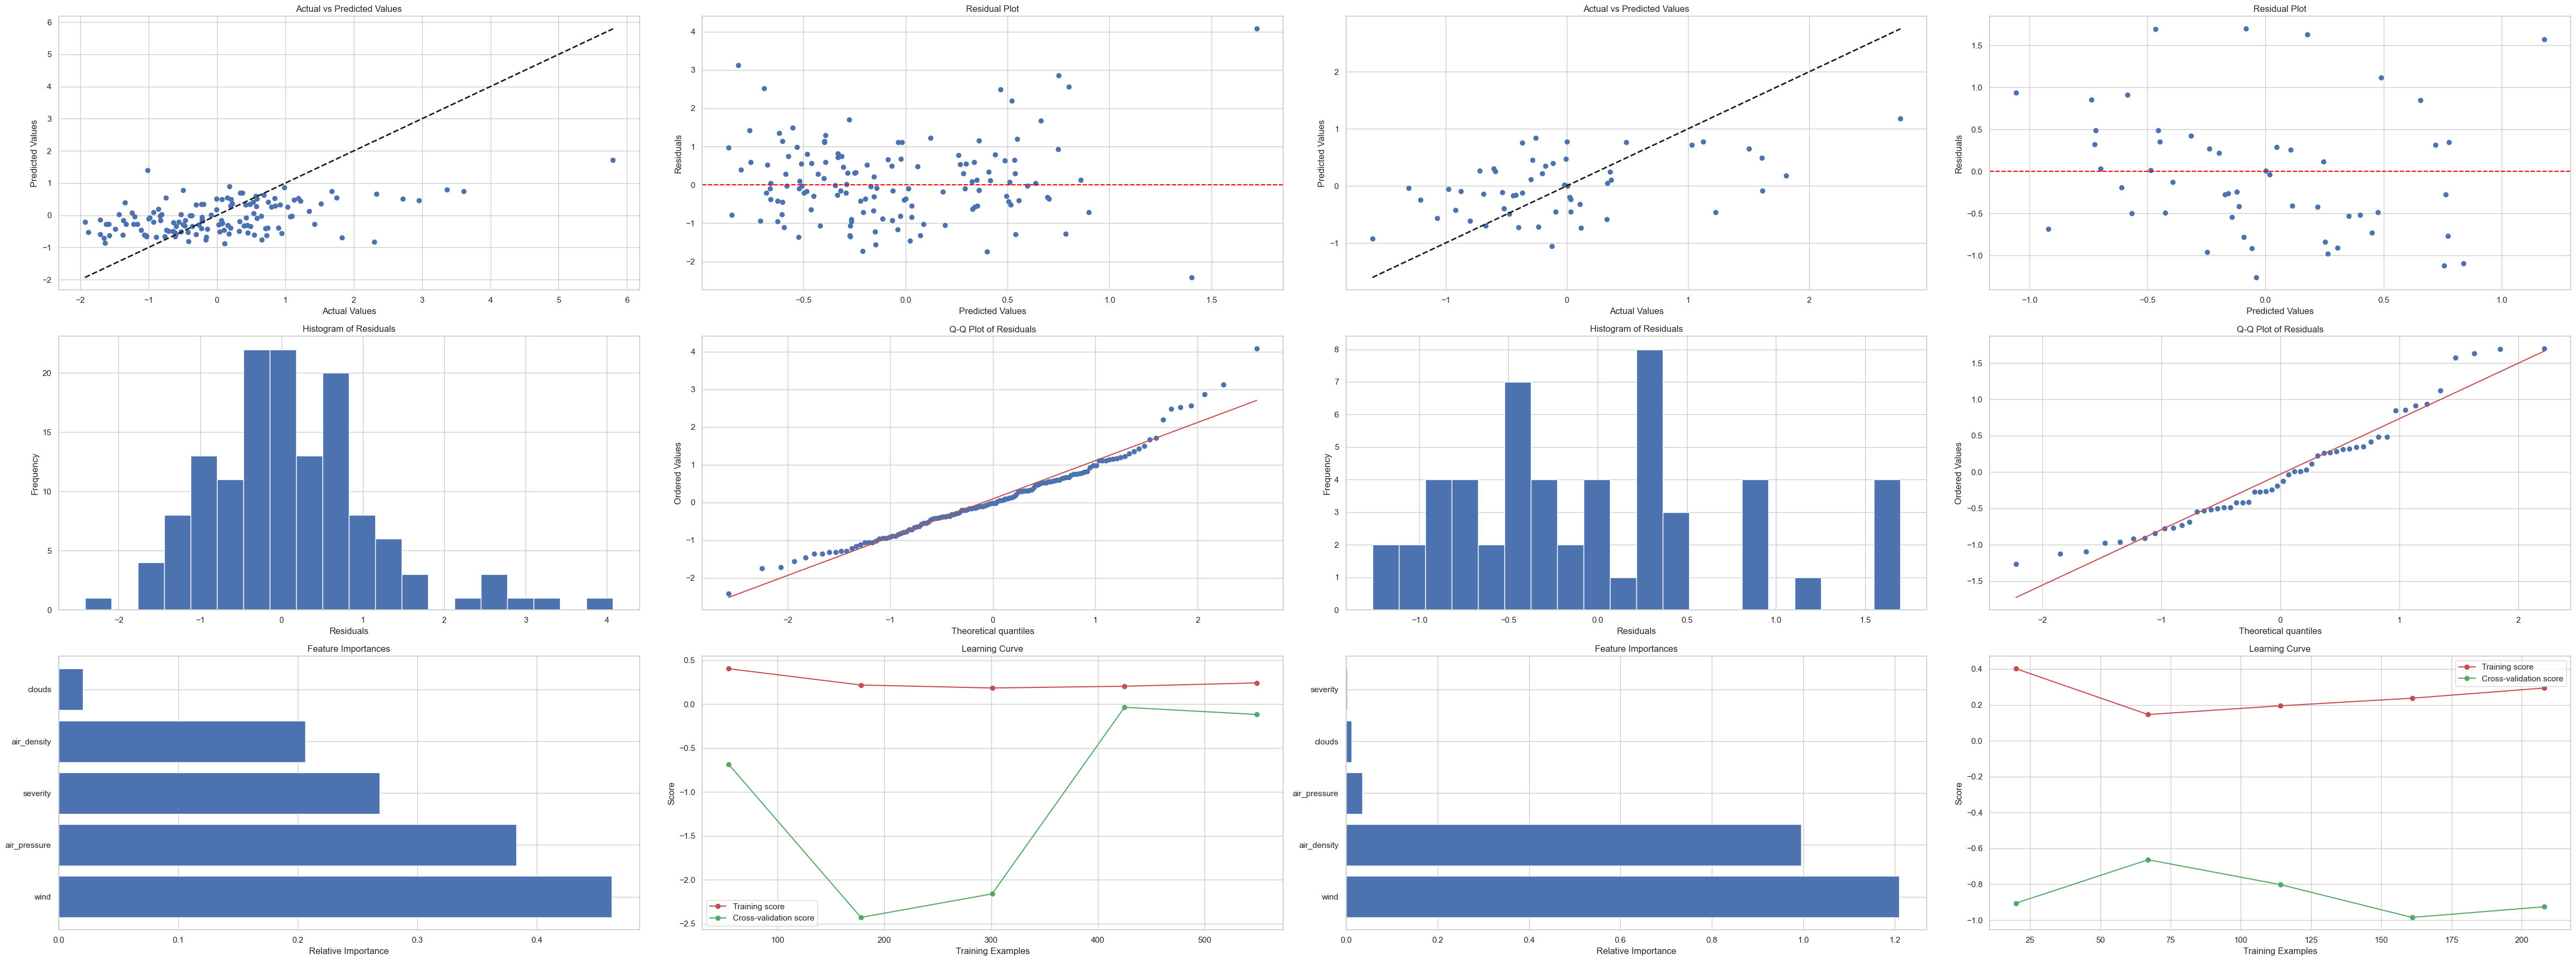

In [174]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots(3, 2*len(aircrafts), figsize = [len(aircraft)*2*6, 3*6])

for i, aircraft in enumerate(aircrafts):
    # Initializing model
    model = LinearRegression()
    
    X = X_dict[aircraft]
    y = y_dict[aircraft]
    X_train = X_train_dict[aircraft]
    X_test = X_test_dict[aircraft]
    y_train = y_train_dict[aircraft].values.reshape(-1, 1)
    y_test = y_test_dict[aircraft].values.reshape(-1, 1)
    
    # scaling data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = scaler.fit_transform(y_train)
    y_test = scaler.transform(y_test)

    # Training model
    model.fit(X_train, y_train)

    # Makeing predictions
    y_pred = model.predict(X_test)

    # Computing statistical metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Perform Kolmogorov-Smirnov test
    #ks_statistic, p_value = kstest(y_test, y_pred)

    # Assuming model.coef_ contains an array of coefficients from a trained model
    coefficients = model.coef_
    
    coefficients = abs(coefficients).ravel()

    # Pair up feature names with their corresponding coefficients
    features_and_coefficients = list(zip(['wind', 'air_density', 'air_pressure', 'clouds', 'severity'], coefficients))

    # Sort the features and their coefficients by the absolute values of the coefficients
    sorted_features_and_coefficients = sorted(features_and_coefficients, key=lambda x: np.abs(x[1]), reverse=True)

    # Unzip into separate lists
    sorted_features, sorted_coefficients = zip(*sorted_features_and_coefficients)

    # Computing residuals
    residuals = y_test - y_pred

    # Computing learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(.1, 1.0, 5), cv=5)

    # Computing mean scores for learning curve
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    print(f"---------{aircraft}---------")
    # Print metrics
    print(f'R-squared: {r2}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root mean squared error: {np.sqrt(mse)}')

    # Print KS statistic
    print(f'KS Statistic: {ks_statistic}')
    print(f'P-value: {p_value}')
    print(f"----------------------")
    
    ax[0, 0+2*i].scatter(y_test, y_pred)
    ax[0, 0+2*i].set_title('Actual vs Predicted Values')
    ax[0, 0+2*i].set_xlabel('Actual Values')
    ax[0, 0+2*i].set_ylabel('Predicted Values')
    ax[0, 0+2*i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line

    ax[0, 1+2*i].scatter(y_pred, residuals)
    ax[0, 1+2*i].set_title('Residual Plot')
    ax[0, 1+2*i].set_xlabel('Predicted Values')
    ax[0, 1+2*i].set_ylabel('Residuals')
    ax[0, 1+2*i].axhline(y=0, color='red', linestyle='--')

    ax[1, 0+2*i].hist(residuals, bins=20)
    ax[1, 0+2*i].set_title('Histogram of Residuals')
    ax[1, 0+2*i].set_xlabel('Residuals')
    ax[1, 0+2*i].set_ylabel('Frequency')

    stats.probplot(residuals.ravel(), dist="norm", plot=ax[1, 1+2*i])
    ax[1, 1+2*i].set_title('Q-Q Plot of Residuals')

    ax[2, 0+2*i].set_title('Feature Importances')
    ax[2, 0+2*i].barh(sorted_features, sorted_coefficients)
    #ax[2, 0+2*i].set_yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    ax[2, 0+2*i].set_xlabel('Relative Importance')

    ax[2, 1+2*i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax[2, 1+2*i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax[2, 1+2*i].set_title('Learning Curve')
    ax[2, 1+2*i].set_xlabel('Training Examples')
    ax[2, 1+2*i].set_ylabel('Score')
    ax[2, 1+2*i].legend(loc="best")
    
    fig.tight_layout()



## Decision Tree Regressor

---------A321---------
R-squared: -0.05834628934417374
Mean Squared Error: 511378.54921409226
Root mean squared error: 715.1073690111803
KS Statistic: 0.10869565217391304
P-value: 0.3898890388244114
----------------------
---------B763---------
R-squared: -0.48605185354744695
Mean Squared Error: 1065726.94916164
Root mean squared error: 1032.3405199650163
KS Statistic: 0.19230769230769232
P-value: 0.29346669559971106
----------------------


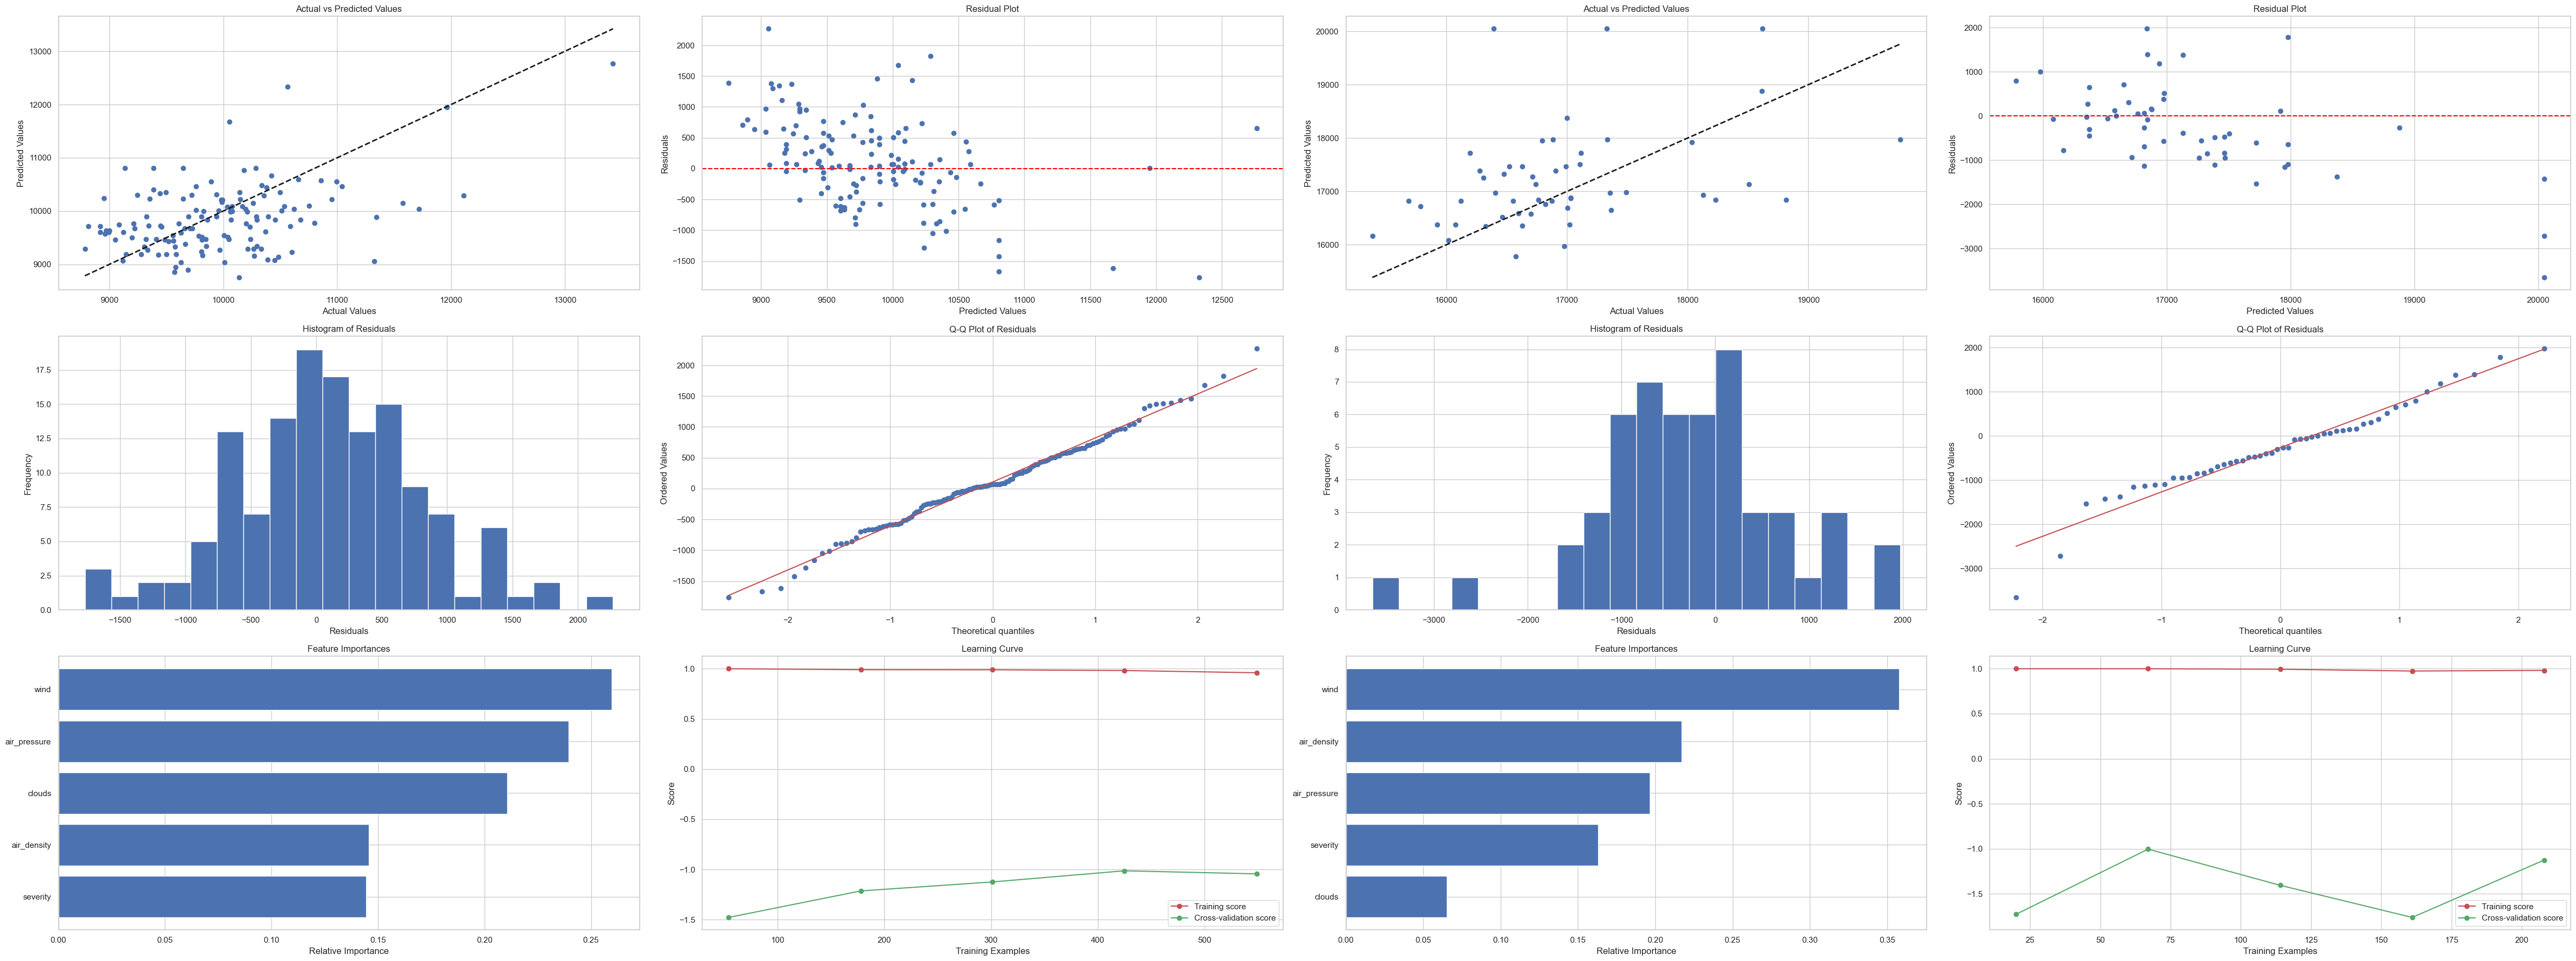

In [175]:
from sklearn.tree import DecisionTreeRegressor

fig, ax = plt.subplots(3, 2*len(aircrafts), figsize = [len(aircraft)*2*6, 3*6])

for i, aircraft in enumerate(aircrafts):
    # Initializing model
    model = DecisionTreeRegressor(max_depth=15)

    X = X_dict[aircraft]
    y = y_dict[aircraft]
    X_train = X_train_dict[aircraft]
    X_test = X_test_dict[aircraft]
    y_train = y_train_dict[aircraft]
    y_test = y_test_dict[aircraft]
    
    # Training model
    model.fit(X_train, y_train)

    # Makeing predictions
    y_pred = model.predict(X_test)

    # Computing statistical metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = kstest(y_test, y_pred)

    # Importance of each feature
    importances = model.feature_importances_
    
    # Computing indices for importance
    indices = np.argsort(importances)

    # Computing residuals
    residuals = y_test - y_pred

    # Computing learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(.1, 1.0, 5), cv=5)

    # Computing mean scores for learning curve
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    print(f"---------{aircraft}---------")
    # Print metrics
    print(f'R-squared: {r2}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root mean squared error: {np.sqrt(mse)}')

    # Print KS statistic
    print(f'KS Statistic: {ks_statistic}')
    print(f'P-value: {p_value}')
    print(f"----------------------")
    
    ax[0, 0+2*i].scatter(y_test, y_pred)
    ax[0, 0+2*i].set_title('Actual vs Predicted Values')
    ax[0, 0+2*i].set_xlabel('Actual Values')
    ax[0, 0+2*i].set_ylabel('Predicted Values')
    ax[0, 0+2*i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line

    ax[0, 1+2*i].scatter(y_pred, residuals)
    ax[0, 1+2*i].set_title('Residual Plot')
    ax[0, 1+2*i].set_xlabel('Predicted Values')
    ax[0, 1+2*i].set_ylabel('Residuals')
    ax[0, 1+2*i].axhline(y=0, color='red', linestyle='--')

    ax[1, 0+2*i].hist(residuals, bins=20)
    ax[1, 0+2*i].set_title('Histogram of Residuals')
    ax[1, 0+2*i].set_xlabel('Residuals')
    ax[1, 0+2*i].set_ylabel('Frequency')

    stats.probplot(residuals, dist="norm", plot=ax[1, 1+2*i])
    ax[1, 1+2*i].set_title('Q-Q Plot of Residuals')

    ax[2, 0+2*i].set_title('Feature Importances')
    ax[2, 0+2*i].barh(range(len(indices)), importances[indices], align='center')
    ax[2, 0+2*i].set_yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    ax[2, 0+2*i].set_xlabel('Relative Importance')

    ax[2, 1+2*i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax[2, 1+2*i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax[2, 1+2*i].set_title('Learning Curve')
    ax[2, 1+2*i].set_xlabel('Training Examples')
    ax[2, 1+2*i].set_ylabel('Score')
    ax[2, 1+2*i].legend(loc="best")
    
fig.tight_layout()


## RandomForestRegressor

---------A321---------
R-squared: 0.2231151519176725
Mean Squared Error: 375380.2044933094
Root mean squared error: 612.6827927184746
KS Statistic: 0.18115942028985507
P-value: 0.021401395223369844
----------------------
---------B763---------
R-squared: 0.24271246949137792
Mean Squared Error: 543091.2303635427
Root mean squared error: 736.9472371639253
KS Statistic: 0.25
P-value: 0.0773384476890688
----------------------


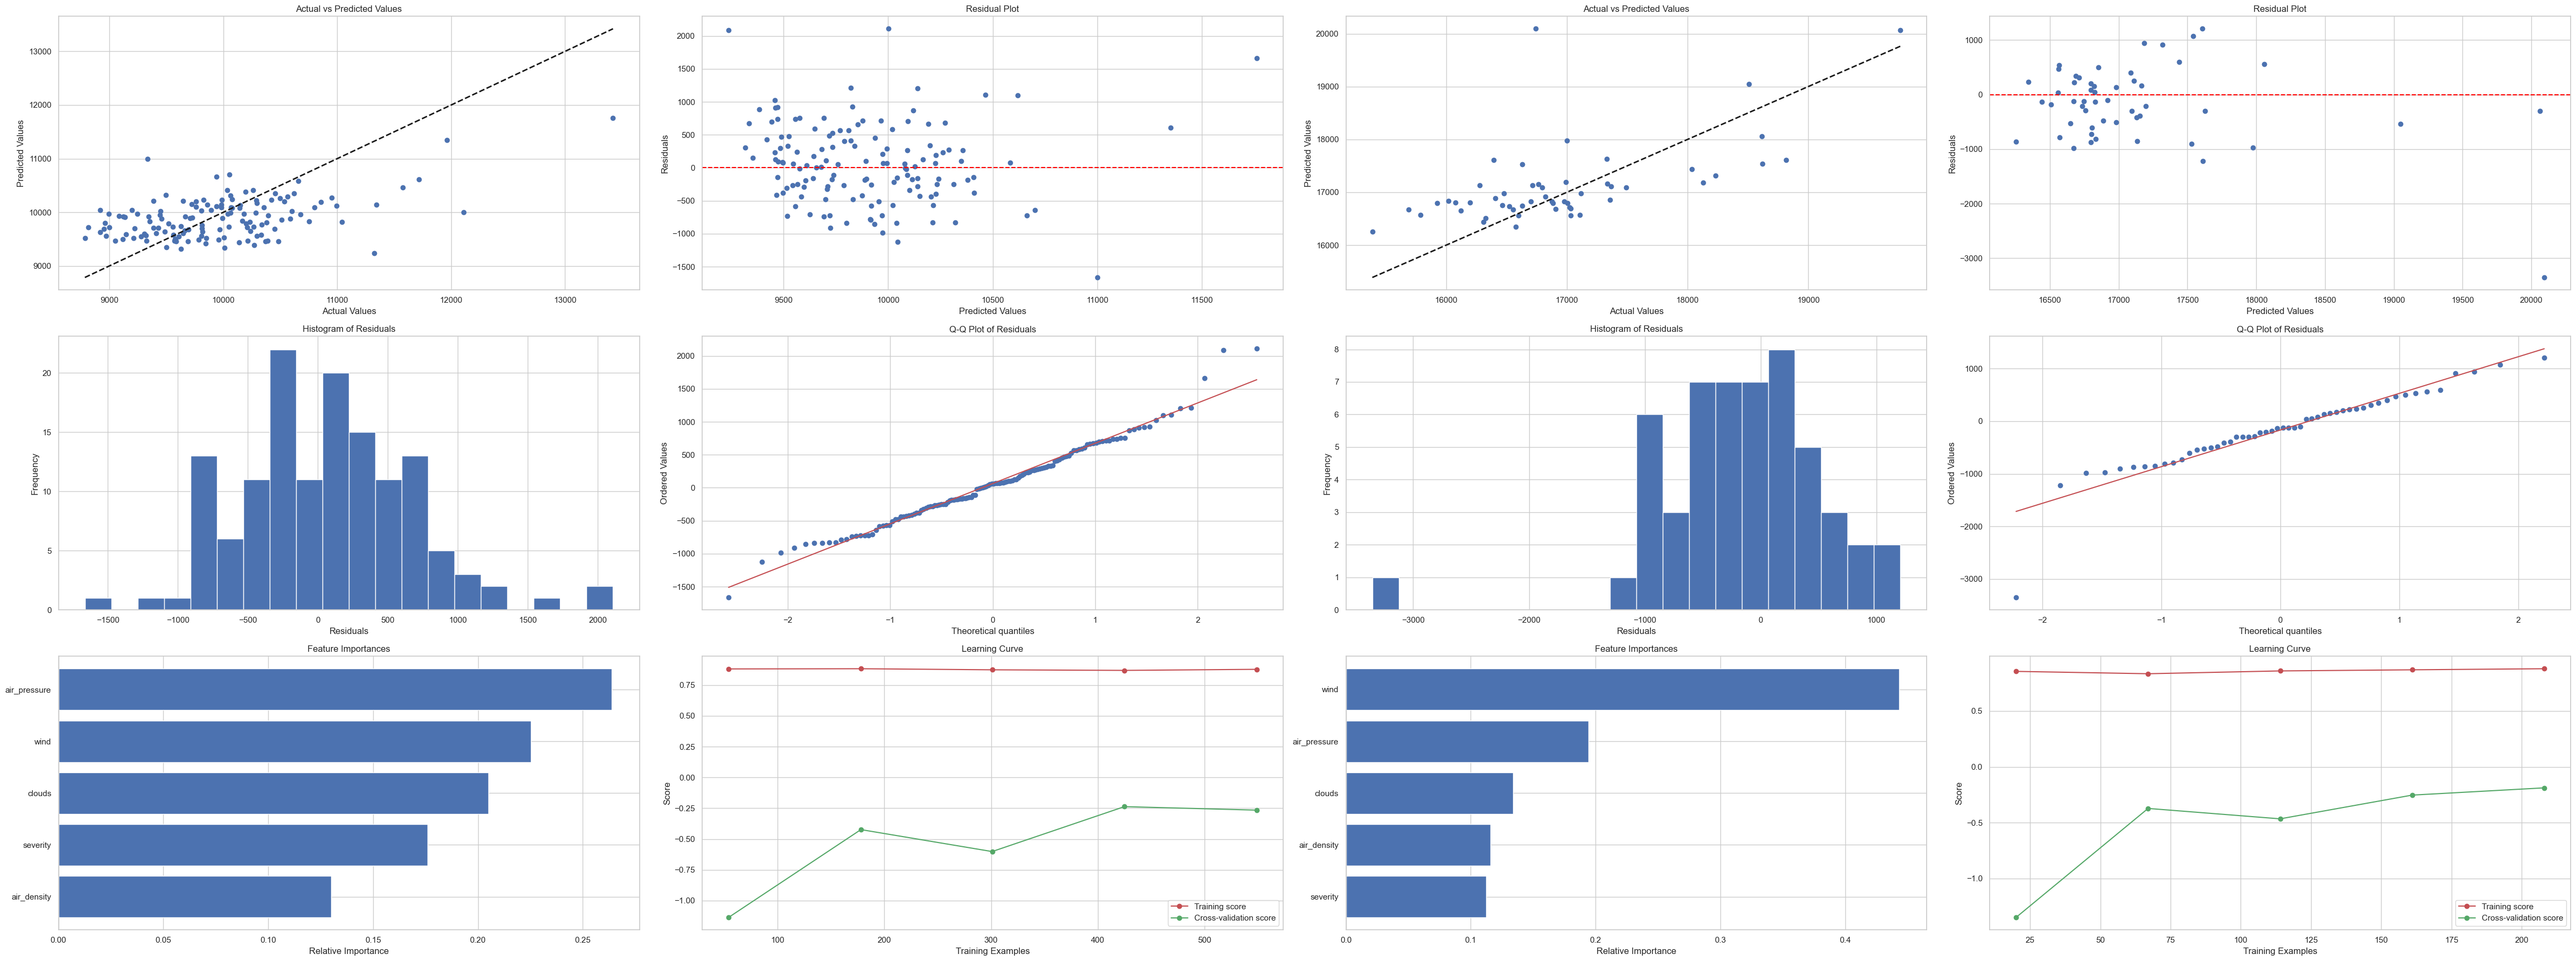

In [176]:
from sklearn.ensemble import RandomForestRegressor

fig, ax = plt.subplots(3, 2*len(aircrafts), figsize = [len(aircraft)*2*6, 3*6])

for i, aircraft in enumerate(aircrafts):
    # Initializing model
    model = RandomForestRegressor(n_estimators=100, max_depth=15)

    X = X_dict[aircraft]
    y = y_dict[aircraft]
    X_train = X_train_dict[aircraft]
    X_test = X_test_dict[aircraft]
    y_train = y_train_dict[aircraft]
    y_test = y_test_dict[aircraft]
    
    # Training model
    model.fit(X_train, y_train)

    # Makeing predictions
    y_pred = model.predict(X_test)

    # Computing statistical metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = kstest(y_test, y_pred)

    # Importance of each feature
    importances = model.feature_importances_
    
    # Computing indices for importance
    indices = np.argsort(importances)

    # Computing residuals
    residuals = y_test - y_pred

    # Computing learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(.1, 1.0, 5), cv=5)

    # Computing mean scores for learning curve
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    print(f"---------{aircraft}---------")
    # Print metrics
    print(f'R-squared: {r2}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root mean squared error: {np.sqrt(mse)}')

    # Print KS statistic
    print(f'KS Statistic: {ks_statistic}')
    print(f'P-value: {p_value}')
    print(f"----------------------")
    
    ax[0, 0+2*i].scatter(y_test, y_pred)
    ax[0, 0+2*i].set_title('Actual vs Predicted Values')
    ax[0, 0+2*i].set_xlabel('Actual Values')
    ax[0, 0+2*i].set_ylabel('Predicted Values')
    ax[0, 0+2*i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line

    ax[0, 1+2*i].scatter(y_pred, residuals)
    ax[0, 1+2*i].set_title('Residual Plot')
    ax[0, 1+2*i].set_xlabel('Predicted Values')
    ax[0, 1+2*i].set_ylabel('Residuals')
    ax[0, 1+2*i].axhline(y=0, color='red', linestyle='--')

    ax[1, 0+2*i].hist(residuals, bins=20)
    ax[1, 0+2*i].set_title('Histogram of Residuals')
    ax[1, 0+2*i].set_xlabel('Residuals')
    ax[1, 0+2*i].set_ylabel('Frequency')

    stats.probplot(residuals, dist="norm", plot=ax[1, 1+2*i])
    ax[1, 1+2*i].set_title('Q-Q Plot of Residuals')

    ax[2, 0+2*i].set_title('Feature Importances')
    ax[2, 0+2*i].barh(range(len(indices)), importances[indices], align='center')
    ax[2, 0+2*i].set_yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    ax[2, 0+2*i].set_xlabel('Relative Importance')

    ax[2, 1+2*i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax[2, 1+2*i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax[2, 1+2*i].set_title('Learning Curve')
    ax[2, 1+2*i].set_xlabel('Training Examples')
    ax[2, 1+2*i].set_ylabel('Score')
    ax[2, 1+2*i].legend(loc="best")
    
fig.tight_layout()


R-squared: 0.9560450436102651
Mean Squared Error: 513612.5477425732
Averaged Mean Squared Error: 513612.5477425732
Root mean squared error: 716.6676689669858
KS Statistic: 0.20526315789473684
P-value: 0.000643997957365305


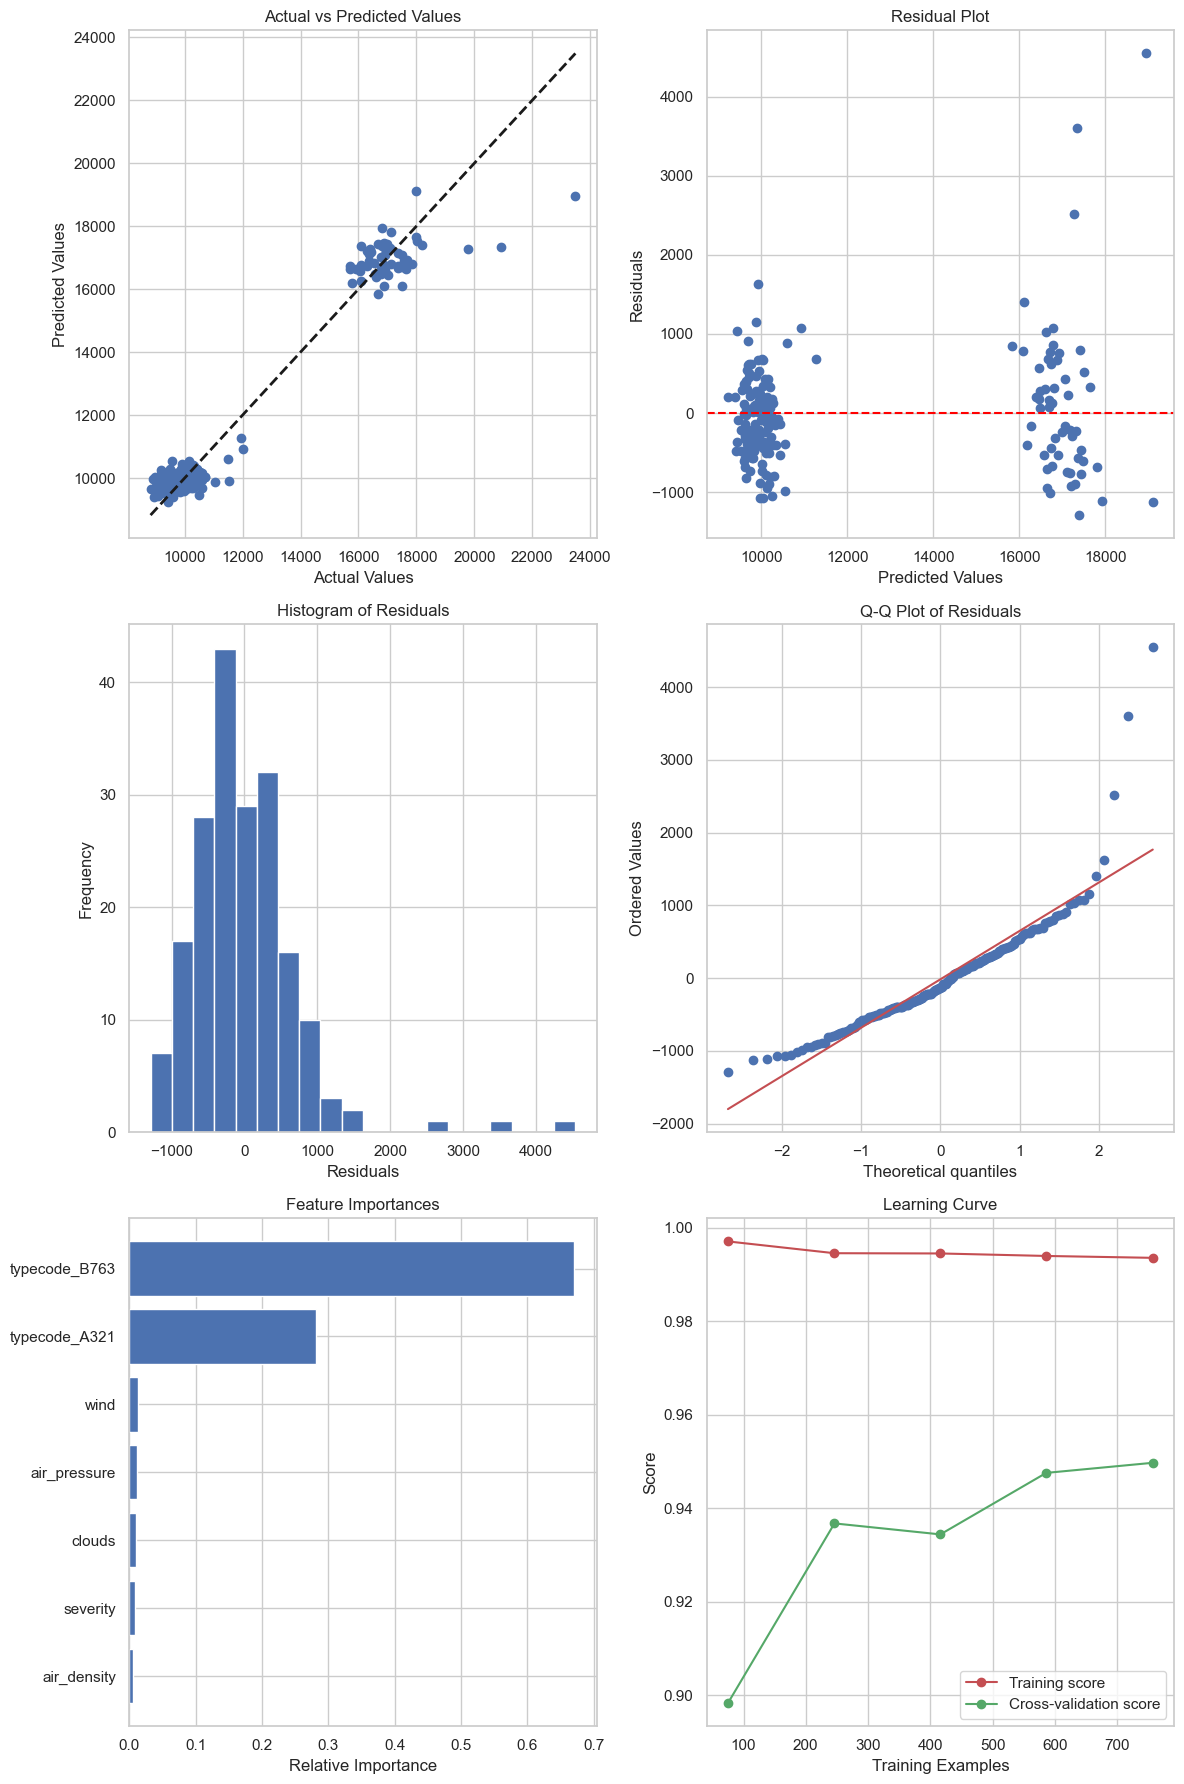

In [178]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import kstest
import scipy.stats as stats
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor

flights_d = pd.get_dummies(flights, columns=['typecode'])

X = flights_d[['wind', 'air_density', 'air_pressure', 'clouds', 'severity', 'typecode_A321', 'typecode_B763']] 
# X = (X - X.min())/(X.max() - X.min())
y = flights_d['fuel']
# y = (y - y.min())/(y.max() - y.min())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

fig, ax = plt.subplots(3, 2, figsize = [2*6, 3*6])

# Initializing model
model = RandomForestRegressor(n_estimators=200, max_depth=15)

# Training model
model.fit(X_train, y_train)

# Makeing predictions
y_pred = model.predict(X_test)

# Computing statistical metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = kstest(y_test, y_pred)

# Importance of each feature
importances = model.feature_importances_

# Computing indices for importance
indices = np.argsort(importances)

# Computing residuals
residuals = y_test - y_pred

# Computing learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, train_sizes=np.linspace(.1, 1.0, 5), cv=5)

# Computing mean scores for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Print metrics
print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')
print(f'Averaged Mean Squared Error: {np.mean(mse)}')
print(f'Root mean squared error: {np.sqrt(mse)}')

# Print KS statistic
print(f'KS Statistic: {ks_statistic}')
print(f'P-value: {p_value}')

ax[0, 0].scatter(y_test, y_pred)
ax[0, 0].set_title('Actual vs Predicted Values')
ax[0, 0].set_xlabel('Actual Values')
ax[0, 0].set_ylabel('Predicted Values')
ax[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line

ax[0, 1].scatter(y_pred, residuals)
ax[0, 1].set_title('Residual Plot')
ax[0, 1].set_xlabel('Predicted Values')
ax[0, 1].set_ylabel('Residuals')
ax[0, 1].axhline(y=0, color='red', linestyle='--')

ax[1, 0].hist(residuals, bins=20)
ax[1, 0].set_title('Histogram of Residuals')
ax[1, 0].set_xlabel('Residuals')
ax[1, 0].set_ylabel('Frequency')

stats.probplot(residuals, dist="norm", plot=ax[1, 1])
ax[1, 1].set_title('Q-Q Plot of Residuals')

ax[2, 0].set_title('Feature Importances')
ax[2, 0].barh(range(len(indices)), importances[indices], align='center')
ax[2, 0].set_yticks(range(len(indices)), [X_train.columns[i] for i in indices])
ax[2, 0].set_xlabel('Relative Importance')

ax[2, 1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[2, 1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[2, 1].set_title('Learning Curve')
ax[2, 1].set_xlabel('Training Examples')
ax[2, 1].set_ylabel('Score')
ax[2, 1].legend(loc="best")
    
fig.tight_layout()


## Support Vector Regression (SVR)

---------A321---------
R-squared: 0.009136068513133977
Mean Squared Error: 478771.990655645
KS Statistic: 0.4927536231884058
P-value: 1.4268420895387074e-15
----------------------
---------B763---------
R-squared: -0.013851563872471884
Mean Squared Error: 727086.9663728521
KS Statistic: 0.5
P-value: 2.8490305688263472e-06
----------------------


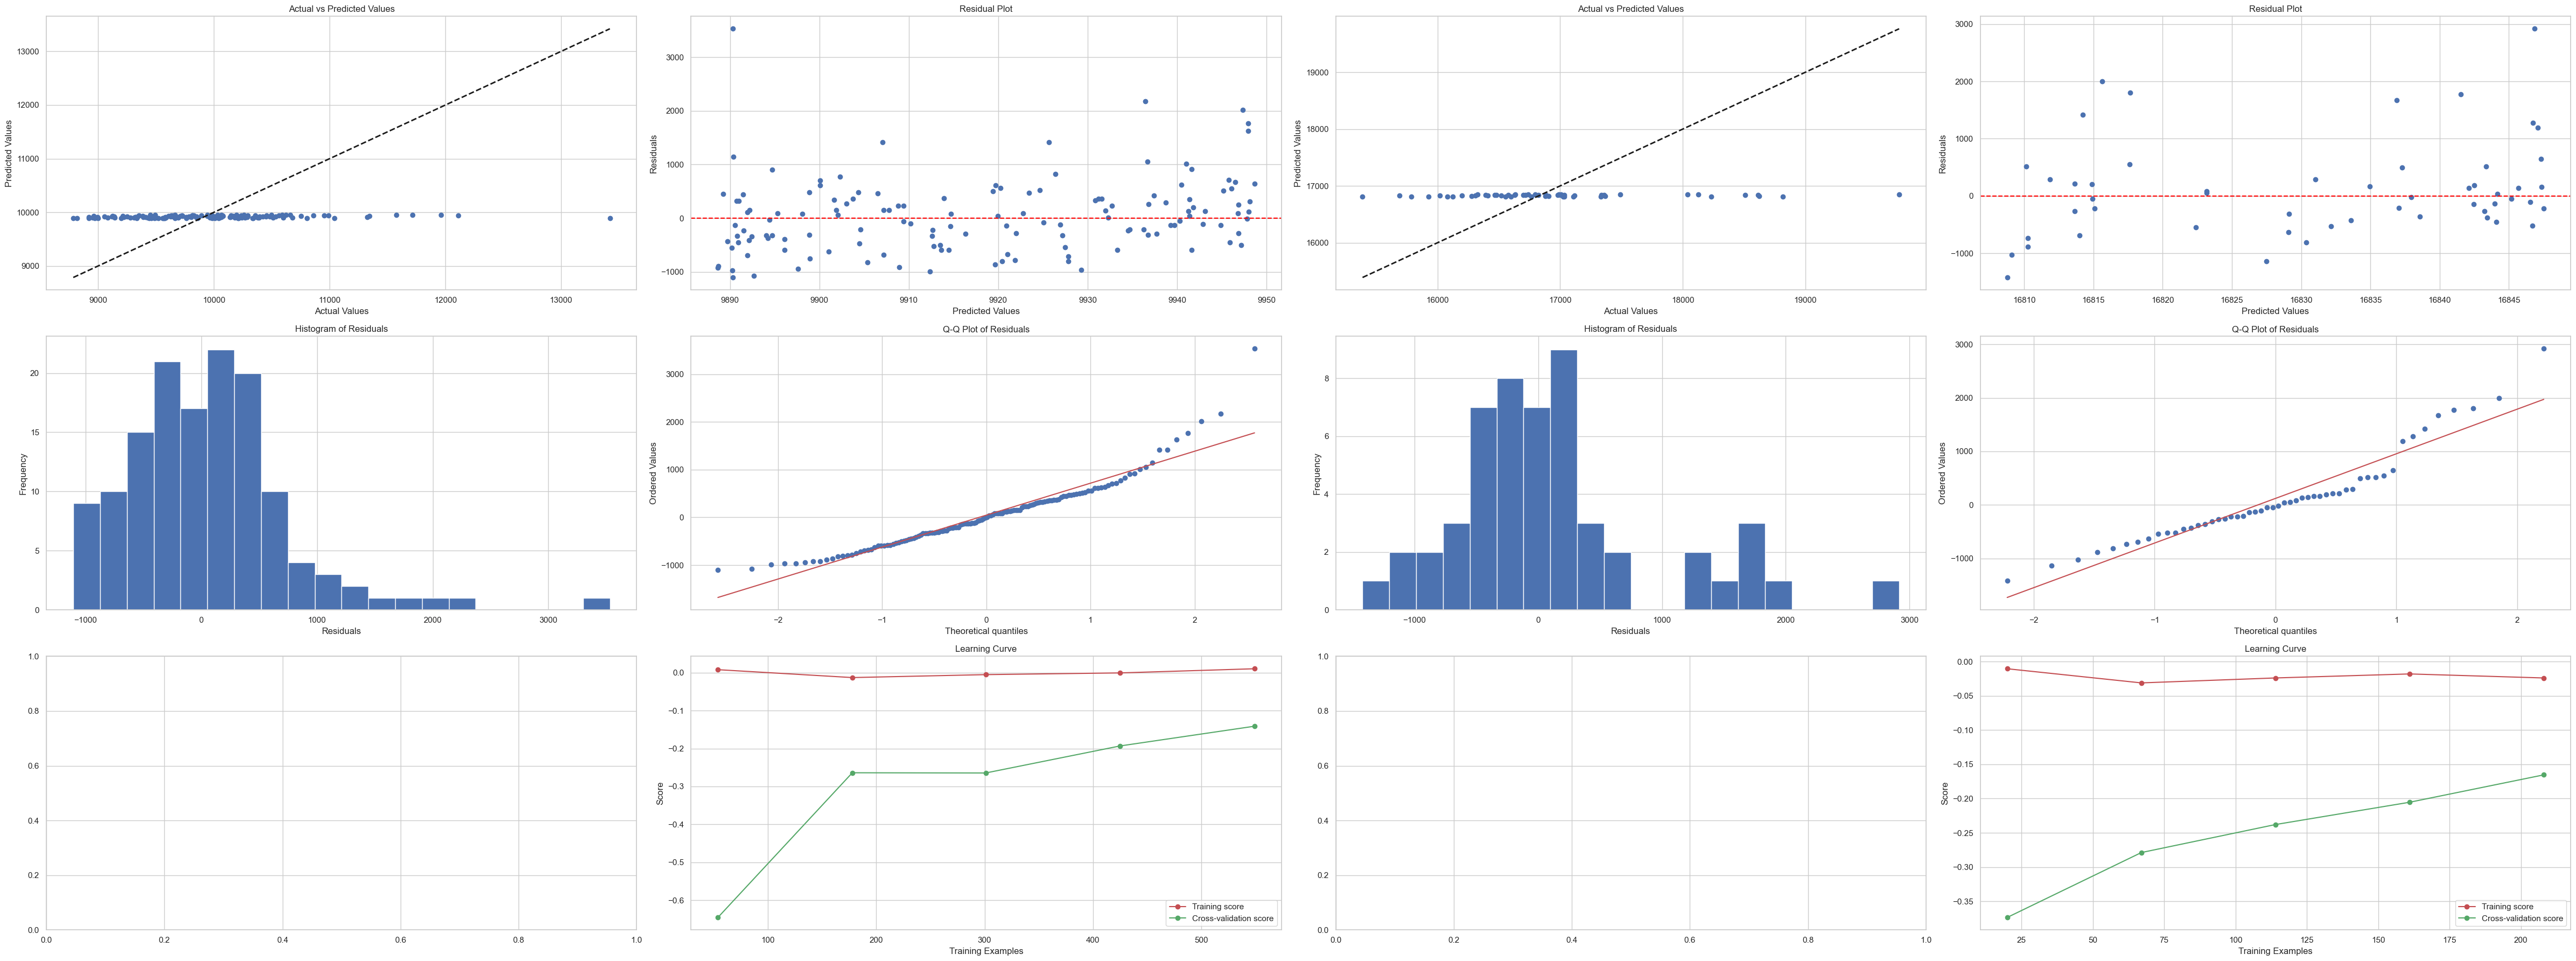

In [179]:
from sklearn.svm import SVR

fig, ax = plt.subplots(3, 2*len(aircrafts), figsize = [len(aircraft)*2*6, 3*6])

for i, aircraft in enumerate(aircrafts):
    # Initializing model
    model = SVR()

    X = X_dict[aircraft]
    y = y_dict[aircraft]
    X_train = X_train_dict[aircraft]
    X_test = X_test_dict[aircraft]
    y_train = y_train_dict[aircraft]
    y_test = y_test_dict[aircraft]
    
    # Training model
    model.fit(X_train, y_train)

    # Makeing predictions
    y_pred = model.predict(X_test)

    # Computing statistical metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = kstest(y_test, y_pred)

    # Computing residuals
    residuals = y_test - y_pred

    # Computing learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(.1, 1.0, 5), cv=5)

    # Computing mean scores for learning curve
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    print(f"---------{aircraft}---------")
    # Print metrics
    print(f'R-squared: {r2}')
    print(f'Mean Squared Error: {mse}')

    # Print KS statistic
    print(f'KS Statistic: {ks_statistic}')
    print(f'P-value: {p_value}')
    print(f"----------------------")
    
    ax[0, 0+2*i].scatter(y_test, y_pred)
    ax[0, 0+2*i].set_title('Actual vs Predicted Values')
    ax[0, 0+2*i].set_xlabel('Actual Values')
    ax[0, 0+2*i].set_ylabel('Predicted Values')
    ax[0, 0+2*i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line

    ax[0, 1+2*i].scatter(y_pred, residuals)
    ax[0, 1+2*i].set_title('Residual Plot')
    ax[0, 1+2*i].set_xlabel('Predicted Values')
    ax[0, 1+2*i].set_ylabel('Residuals')
    ax[0, 1+2*i].axhline(y=0, color='red', linestyle='--')

    ax[1, 0+2*i].hist(residuals, bins=20)
    ax[1, 0+2*i].set_title('Histogram of Residuals')
    ax[1, 0+2*i].set_xlabel('Residuals')
    ax[1, 0+2*i].set_ylabel('Frequency')

    stats.probplot(residuals, dist="norm", plot=ax[1, 1+2*i])
    ax[1, 1+2*i].set_title('Q-Q Plot of Residuals')

#     ax[2, 0+2*i].set_title('Feature Importances')
#     ax[2, 0+2*i].barh(range(len(indices)), importances[indices], align='center')
#     ax[2, 0+2*i].set_yticks(range(len(indices)), [X_train.columns[i] for i in indices])
#     ax[2, 0+2*i].set_xlabel('Relative Importance')

    ax[2, 1+2*i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax[2, 1+2*i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax[2, 1+2*i].set_title('Learning Curve')
    ax[2, 1+2*i].set_xlabel('Training Examples')
    ax[2, 1+2*i].set_ylabel('Score')
    ax[2, 1+2*i].legend(loc="best")
    
fig.tight_layout()


## Neural Networks

/Users/dumindu/anaconda3/envs/conda2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dumindu/anaconda3/envs/conda2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dumindu/anaconda3/envs/conda2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dumindu/anaconda3/envs/conda2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converge

---------A321---------
R-squared: -151.67929387875014
Mean Squared Error: 73772560.63053736
KS Statistic: 1.0
P-value: 3.4328834093154043e-82
----------------------


/Users/dumindu/anaconda3/envs/conda2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dumindu/anaconda3/envs/conda2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dumindu/anaconda3/envs/conda2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dumindu/anaconda3/envs/conda2/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converge

---------B763---------
R-squared: -369.7988133899656
Mean Squared Error: 265919582.28342345
KS Statistic: 1.0
P-value: 1.263371326194435e-30
----------------------


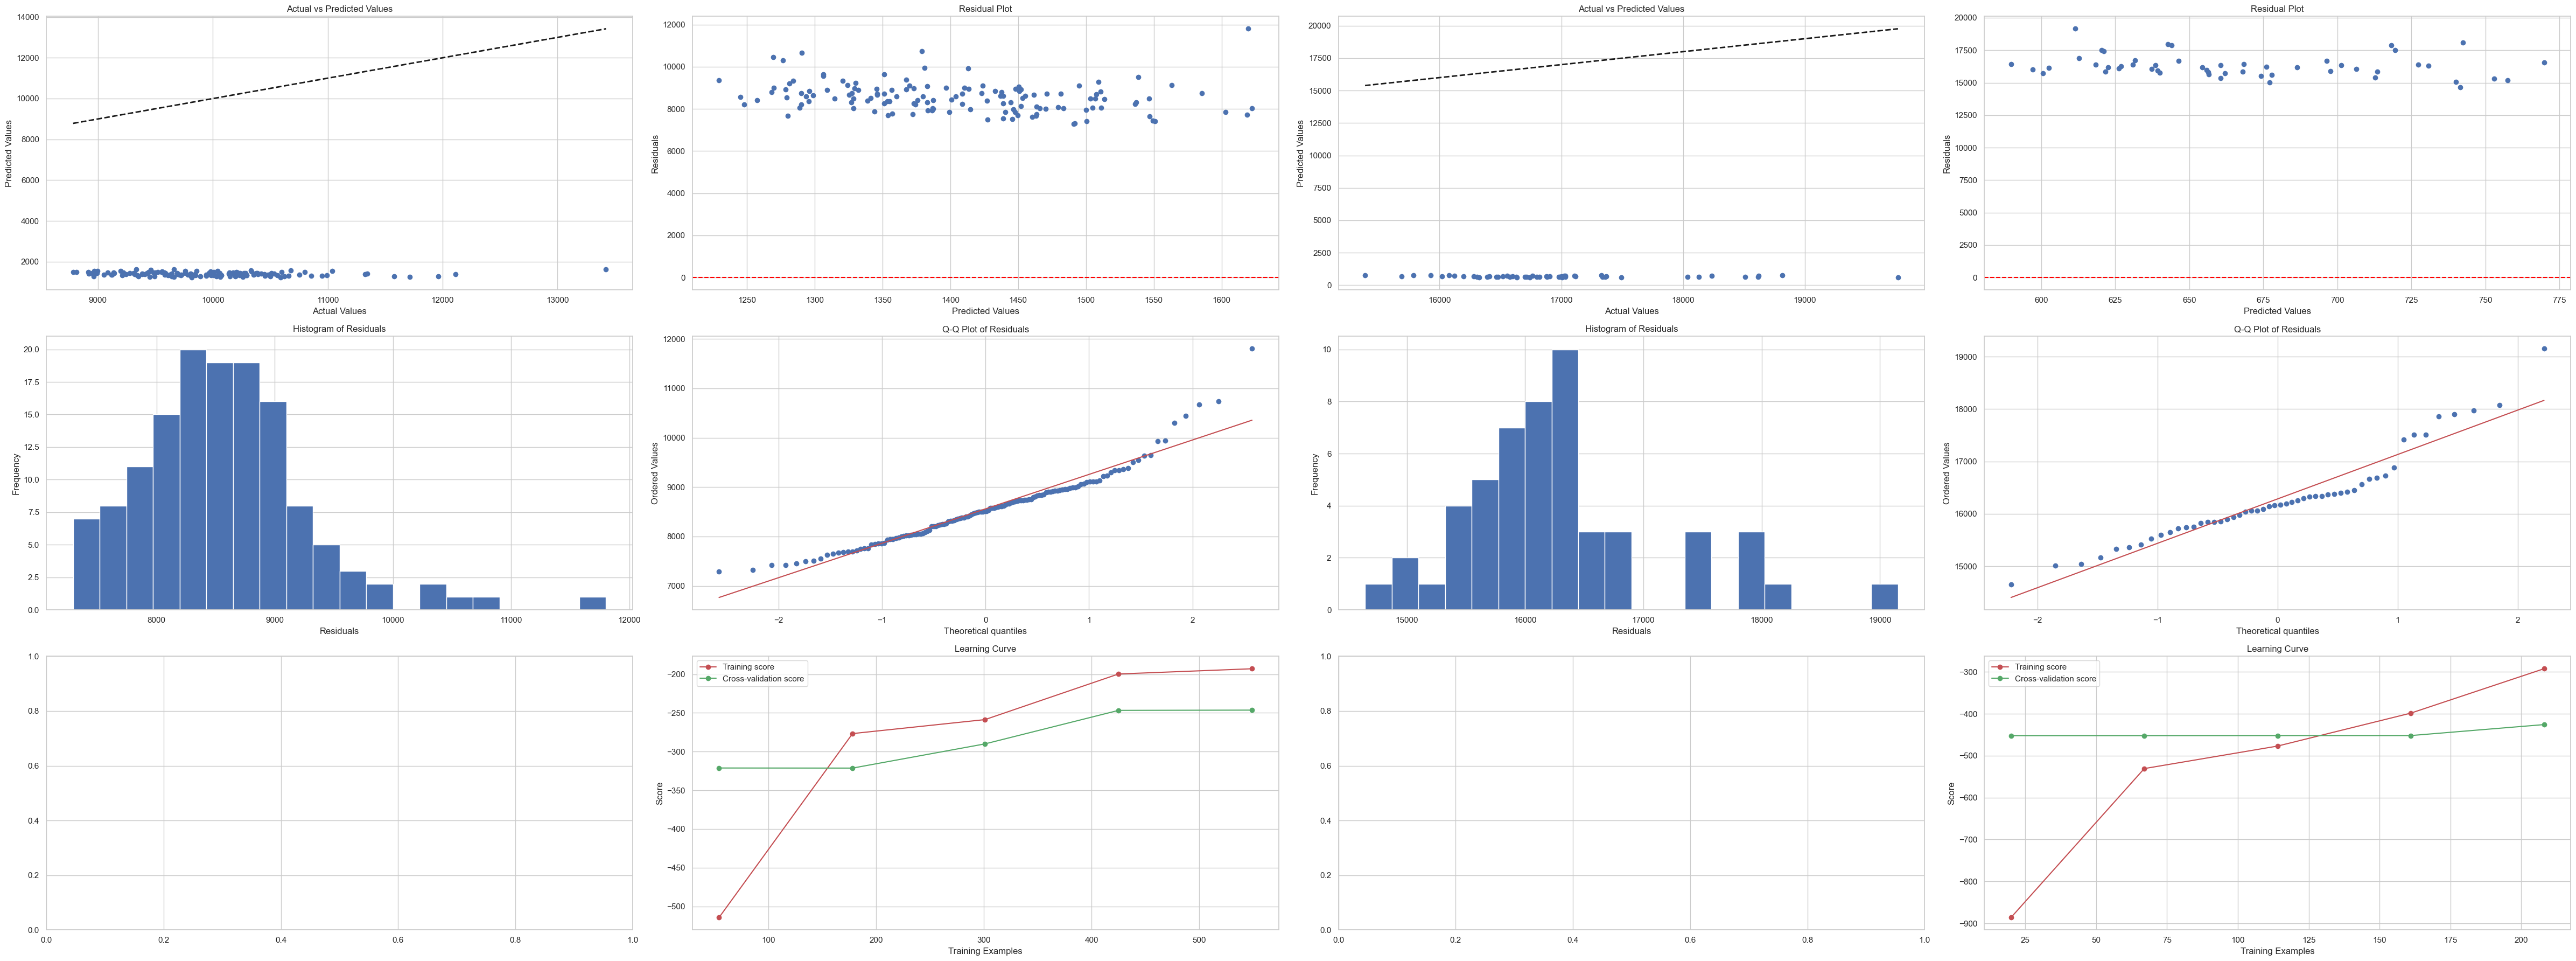

In [181]:
from sklearn.neural_network import MLPRegressor

fig, ax = plt.subplots(3, 2*len(aircrafts), figsize = [len(aircraft)*2*6, 3*6])

for i, aircraft in enumerate(aircrafts):
    # Initializing model
    model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

    X = X_dict[aircraft]
    y = y_dict[aircraft]
    X_train = X_train_dict[aircraft]
    X_test = X_test_dict[aircraft]
    y_train = y_train_dict[aircraft]
    y_test = y_test_dict[aircraft]
    
    # Training model
    model.fit(X_train, y_train)

    # Makeing predictions
    y_pred = model.predict(X_test)

    # Computing statistical metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = kstest(y_test, y_pred)

    # Computing residuals
    residuals = y_test - y_pred

    # Computing learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(.1, 1.0, 5), cv=5)

    # Computing mean scores for learning curve
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    print(f"---------{aircraft}---------")
    # Print metrics
    print(f'R-squared: {r2}')
    print(f'Mean Squared Error: {mse}')

    # Print KS statistic
    print(f'KS Statistic: {ks_statistic}')
    print(f'P-value: {p_value}')
    print(f"----------------------")
    
    ax[0, 0+2*i].scatter(y_test, y_pred)
    ax[0, 0+2*i].set_title('Actual vs Predicted Values')
    ax[0, 0+2*i].set_xlabel('Actual Values')
    ax[0, 0+2*i].set_ylabel('Predicted Values')
    ax[0, 0+2*i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line

    ax[0, 1+2*i].scatter(y_pred, residuals)
    ax[0, 1+2*i].set_title('Residual Plot')
    ax[0, 1+2*i].set_xlabel('Predicted Values')
    ax[0, 1+2*i].set_ylabel('Residuals')
    ax[0, 1+2*i].axhline(y=0, color='red', linestyle='--')

    ax[1, 0+2*i].hist(residuals, bins=20)
    ax[1, 0+2*i].set_title('Histogram of Residuals')
    ax[1, 0+2*i].set_xlabel('Residuals')
    ax[1, 0+2*i].set_ylabel('Frequency')

    stats.probplot(residuals, dist="norm", plot=ax[1, 1+2*i])
    ax[1, 1+2*i].set_title('Q-Q Plot of Residuals')

#     ax[2, 0+2*i].set_title('Feature Importances')
#     ax[2, 0+2*i].barh(range(len(indices)), importances[indices], align='center')
#     ax[2, 0+2*i].set_yticks(range(len(indices)), [X_train.columns[i] for i in indices])
#     ax[2, 0+2*i].set_xlabel('Relative Importance')

    ax[2, 1+2*i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax[2, 1+2*i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax[2, 1+2*i].set_title('Learning Curve')
    ax[2, 1+2*i].set_xlabel('Training Examples')
    ax[2, 1+2*i].set_ylabel('Score')
    ax[2, 1+2*i].legend(loc="best")
    
fig.tight_layout()
